<h2><font color="#004D7F" size=4>UniversityHack2020</font></h2>

<img src="data/logo-light.png" align="right">

<h1><font color="#004D7F" size=5>Reto Minsait Land Classification</font></h1>


<br><br>
<div style="text-align: right">
<font color="#004D7F" size=3><a href="https://www.linkedin.com/in/cifucg">Cristian Cifuentes García</a>, <a href="https://www.linkedin.com/in/manuelbermudezmartinez/">Manuel Bermúdez Martínez</a></font><br>
<font color="#004D7F" size=3>Curso de Especialista en Ciencia de Datos y Desarrollo de Aplicaciones en la Nube </font><br>
<font color="#004D7F" size=3>Universidad de Castilla-La Mancha</font>

---

<a id="indice"></a>
<h2><font color="#004D7F" size=5>Índice</font></h2>

* [1. Introducción](#section1)
* [2. Requisitos](#section2)
* [3. Análisis exploratorio de los datos](#section3)
    * [3.1 Tratamiento de las columnas numéricas](#section31)
        * [3.1.1 Variables relativas al Geoposicionamiento](#section311)
        * [3.1.2 Variables relativas a los Colores](#section312)
        * [3.1.3 Variables relativas a la Geometría](#section313)
        * [3.1.4 Variables relativas al año de construcción y máximo de pisos de los edificios colindantes](#section314)
    * [3.2 Tratamiento de las columnas discretas](#section32)
* [4. Preprocesamiento del conjunto de datos](#section4)
* [5. Construcción de modelos](#section5)
    * [5.1 Construcción de modelo binario](#section51)
    * [5.2 Construcción de modelo multietiqueta](#section52)
* [6. Validación de nuevos datos](#section6)
* [7. Prediccion de los datos a estimar](#section7)
<br>
---

<a id="section1"></a>
## <font color="#004D7F"> 1. Introducción</font>

<h3><center>Utiliza la información de las imágenes de satélite para clasificar el suelo.</center></h3>

Actualmente, un gran número de satélites toman imágenes con distintos fines y usos. El gran número de imágenes y la gran cantidad de datos que se obtienen de las mismas hace necesario crear modelos predictivos para identificar el contenido de la imagen.

En este reto se disponen de las variables extraídas de la imagen y georeferenciadas, así como variables categóricas asociadas al entorno para estimar un modelo.

<h3><center>Objetivo</center></h3>

El reto consiste en encontrar el mejor modelo de clasificación automática de suelos en base a las imágenes proporcionadas por el satélite Sentinel II del servicio Copernicus de la Agencia Espacial Europea.

En este reto disponemos de un conjunto de fincas catastrales asociados a una lista de atributos extraídos de la imagen.

Para ello podemos utilizar las distintas técnicas de Machine Learning disponibles para este tipo de problemas.

La métrica objetivo a maximizar es la “Exactitud”, definida como el “Número de registros correctamente clasificados / Número total de registros proporcionados por la Organización”.

<img src="data/mapa_introduccion.jpg">

<h3><center>El Dataset</center></h3>

El dataset contiene un listado de superficies sobre las que se han recortado la imagen de satélite y se han extraído una serie de características de sus geometrías. Finalmente se ha etiquetado el conjunto de los datos según una clasificación de suelo.

---

<a id="section2"></a>
## <font color="#004D7F"> 2. Requisitos</font>

Esta celda está destinada a la importación de los paquetes y librerías necesarias para el desarrollo del problema.

<div class="alert alert-block alert-danger">
    
<i class="fa fa-exclamation-triangle" aria-hidden="true"></i>
Es necesario tener instaladas todas las librerías, la mayoría de ellas se pueden instalar mediante el comando `pip` en el terminal.
</div>

In [1]:
# Librerias para el tratamiento de los datos
import pandas as pd
import numpy as np

# Librerias para la graficación de los datost
import matplotlib.pyplot as plt
import seaborn as sns;
sns.set()
import plotly.express as px

# Permite que las graficas se generen a mayor resolucion
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Permite ignorar los warnings de la libreta al generar algunos modelos
import warnings
warnings.simplefilter('ignore')

# Establece un ancho de libreta mayor
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

# Libreria necesaria para los gráficos interactivos
from ipywidgets import interact 

# Librerias necesarias para el aprendizaje de modelos
#from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from sklearn.model_selection import GridSearchCV, train_test_split

#Modelos
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier

#Métricas
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

#Medicion de tiempos
import time

Las siguientes funciones nos van a permitir obtener y visualizar la matriz de confusión de los modelos que entrenemos en la sección [Construcción de modelos](#section5).

In [2]:
def show_results(y, y_pred):
    sns.heatmap(confusion_matrix(y, y_pred), square=True, annot=True, fmt='d', cbar=True, cmap=plt.cm.Blues)
    plt.ylabel('Clase real')
    plt.xlabel('Predicción');
    plt.gca().set_ylim(2.0, 0)
    plt.show()
    print('\033[1mAccuracy\033[0m: {}'.format(round(accuracy_score(y, y_pred), 3)))
    print(classification_report(y, y_pred))

In [3]:
def show_results_multilabel(y, y_pred):
    c_r = classification_report(y, y_pred, output_dict=True)
    target_names = [key for key in c_r.keys()][:-3] #Obtenemos las etiquetas para que coincidan con las de la matriz de confusión

    sns.heatmap(confusion_matrix(y, y_pred), square=True, annot=True, fmt='d', cbar=True, cmap=plt.cm.Blues)
    plt.ylabel('Clase real')
    plt.xlabel('Predicción');
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names, rotation=0)
    plt.show()
    print('\033[1mAccuracy\033[0m: {}'.format(round(accuracy_score(y, y_pred), 3)))
    print(classification_report(y, y_pred, target_names=target_names))

Función necesaria para la visualización de la _Curva ROC_ y del _Área bajo la curva_.

In [4]:
def plot_roc_curve(y_test, y_pred):
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

Cargamos el conjunto de datos proporcionado en un fichero de texto plano y lo convertimos en un *dataframe* de *pandas*. Este operación tiene la finalidad de permitirnos trabajar de una forma más rápida y eficiente con el conjunto de datos y así, poder realizar un buen análisis exploratorio del mismo.

In [5]:
df = pd.read_csv('data/Modelar_UH2020.txt', sep="|", index_col='ID', encoding='utf-8')
print("Tamaño del conjunto de datos:  %d" % df.shape[0])
print("Número de variables: %d" % df.shape[1])
if df.index.is_unique:
    print('El índice es único.')
else:
    print('Los índices están duplicados.')

Tamaño del conjunto de datos:  103230
Número de variables: 55
El índice es único.


Podemos observar que contamos con un total de <b>103230 datos</b>, es decir, con una gran cantidad de registros. Este elevado número nos puede ayudar, en gran parte, a desarrollar un modelo con un rendimiento acertado. Por otro lado, contamos con <b>56 variables</b>, pero se ha establecido como índice del conjunto de datos la variable `ID`, tras comprobar que realmente es un identificador único y no se repite, por lo que, <b>el número de variables disminuye a 55.</b>

Vamos a dividir el conjunto de datos almacenado en `df` en dos: `df_modelar` con el 85% de los datos, y que será utilizado en el proceso de aprendizaje de los modelos; y `df_modelar_new`, con el 15% restante para validar los modelos previamente entrenados. 

<div class="alert alert-block alert-warning">
    
<i class="fa fa-exclamation-circle" aria-hidden="true"></i> El conjunto de datos `df_modelar_new` __no debe ser utilizado en ninguna fase del proceso de aprendizaje__, ni siquiera para la exploración, preprocesamiento, o la selección del modelo.
</div>

In [6]:
X = df.drop(columns=['CLASE']).copy()
y = df['CLASE'].copy()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, stratify=y, shuffle=True, random_state=10)

df_modelar = X_train.merge(y_train, on='ID')
df_modelar_new = X_val.merge(y_val, on='ID')

print("Tamaño del conjunto de datos disponibles: ", len(df_modelar))
print("Tamaño del conjunto de nuevos datos: ", len(df_modelar_new))

Tamaño del conjunto de datos disponibles:  87745
Tamaño del conjunto de nuevos datos:  15485


In [7]:
list_class_order = ['RESIDENTIAL', 'PUBLIC', 'RETAIL', 'OFFICE', 'INDUSTRIAL', 'AGRICULTURE', 'OTHER']

Esta lista presenta como finalidad la representación de las variables en el mismo orden y con el mismo color asociado en todas aquellas gráficas que las utilicemos. 

Y en la siguiente celda se define una lista en la cual se irán añadiendo las diferentes funciones que se aplicarán en el apartado de preprocesamiento del conjunto de datos

In [8]:
list_preprocess_function = []

---
<a id="section3"></a>
## <font color="#004D7F"> 3. Análisis exploratorio de los datos</font> 

En una primera toma de contacto con los datos, podemos ver una pequeña parte del conjunto para ver qué valores toman cada una de las 55 variables:

In [9]:
df_modelar.head()

,X,Y,Q_R_4_0_0,Q_R_4_0_1,Q_R_4_0_2,Q_R_4_0_3,Q_R_4_0_4,Q_R_4_0_5,Q_R_4_0_6,Q_R_4_0_7,...,Q_NIR_8_1_0,AREA,GEOM_R1,GEOM_R2,GEOM_R3,GEOM_R4,CONTRUCTIONYEAR,MAXBUILDINGFLOOR,CADASTRALQUALITYID,CLASE
ID,,,,,,,,,,,,,,,,,,,,,
32495F6F5B3D012D,2218599328,165740446,0.000000e+00,341.999185,508.998688,644.999683,767.999805,889.001648,1019.992651,1173.999329,...,6719.040030,280.099835,0.147746,0.026358,0.020012,0.759253,1998,3.0,3,RESIDENTIAL
F3DED6C32C3AF640,2274027356,165666951,2.796403e-11,519.999756,656.998657,752.000092,840.000061,936.998871,1049.999878,1209.999023,...,7173.107369,274.522959,0.450799,0.066489,0.024697,0.371450,1973,2.0,5,RESIDENTIAL
7B3EE36498F19B20,2212893511,165655704,0.000000e+00,364.999878,548.002014,696.005035,828.997742,954.005249,1098.000244,1262.999084,...,7545.798645,536.030810,0.511855,0.031980,0.029860,0.933712,1964,6.0,5,RESIDENTIAL
AAE6E75EF15C8FFE,2225521292,165661643,0.000000e+00,316.997635,503.003845,655.999390,798.997314,941.999359,1097.001221,1271.008667,...,5448.082132,581.658490,0.330438,0.022326,0.025445,1.139707,1992,5.0,5,RESIDENTIAL
5A4E48F0B5A2EF0B,2205830838,165864858,0.000000e+00,357.002701,513.001526,636.004059,758.998230,888.000305,1041.995117,1216.001160,...,12361.802028,41.907200,0.685767,0.238095,0.068729,0.288660,1965,1.0,7,RESIDENTIAL


Las variables y el tipo de datos de cada una de ellas es el siguiente:

In [10]:
df_modelar.dtypes

X                       int64
Y                       int64
Q_R_4_0_0             float64
Q_R_4_0_1             float64
Q_R_4_0_2             float64
Q_R_4_0_3             float64
Q_R_4_0_4             float64
Q_R_4_0_5             float64
Q_R_4_0_6             float64
Q_R_4_0_7             float64
Q_R_4_0_8             float64
Q_R_4_0_9             float64
Q_R_4_1_0             float64
Q_G_3_0_0             float64
Q_G_3_0_1             float64
Q_G_3_0_2             float64
Q_G_3_0_3             float64
Q_G_3_0_4             float64
Q_G_3_0_5             float64
Q_G_3_0_6             float64
Q_G_3_0_7             float64
Q_G_3_0_8             float64
Q_G_3_0_9             float64
Q_G_3_1_0             float64
Q_B_2_0_0             float64
Q_B_2_0_1             float64
Q_B_2_0_2             float64
Q_B_2_0_3             float64
Q_B_2_0_4             float64
Q_B_2_0_5             float64
Q_B_2_0_6             float64
Q_B_2_0_7             float64
Q_B_2_0_8             float64
Q_B_2_0_9 

Se ve a simple vista que predominan las variables numéricas y que el conjunto de datos presenta muy pocas variables discretas. De todas formas, realizaremos un tratamiento específico para cada una de ellas en el apartado correspondiente. 

Hay que tener en cuenta que el principal problema de este reto es el desbalanceo de las clases y por ello mismo, se debe de comprobar cuantos registros tenemos para cada uno de los diferentes valores de la objetivo o a predecir, que es la variable `CLASE`.

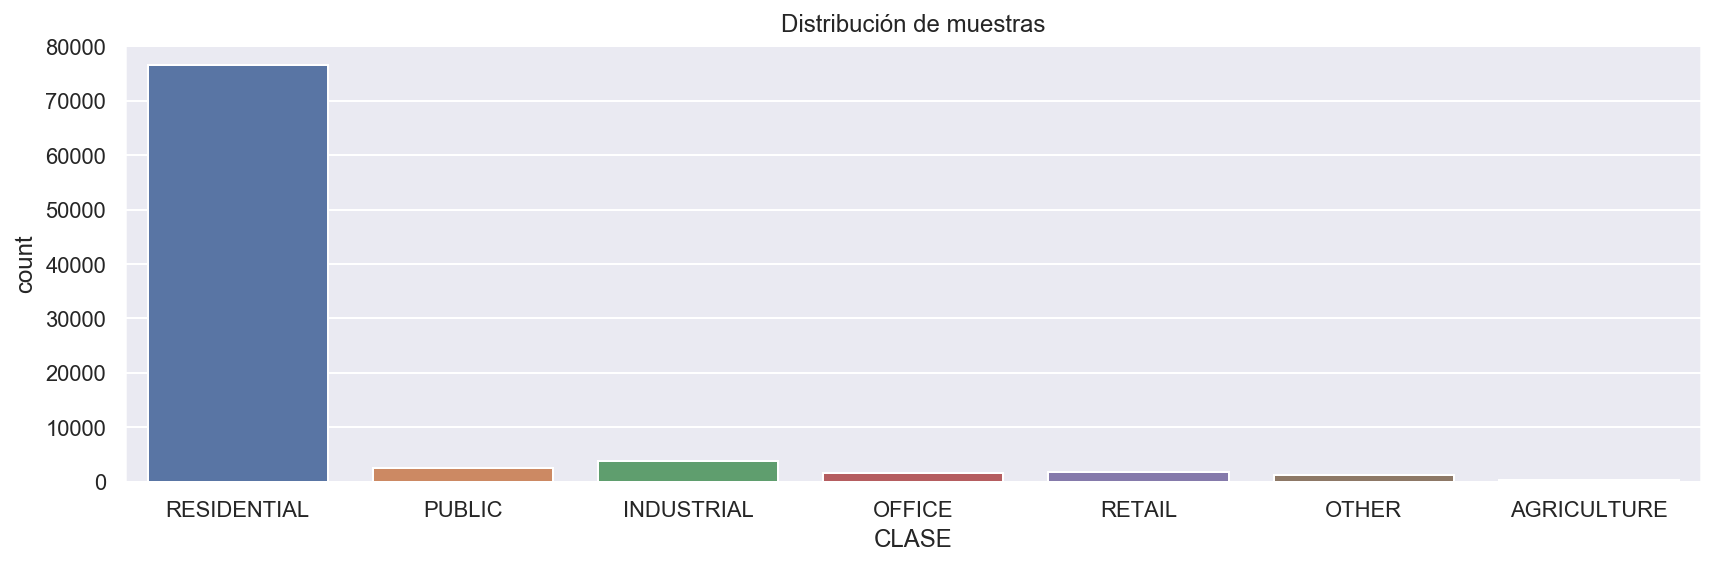

In [11]:
plt.figure(figsize=(12,4))
sns.countplot(x='CLASE', data=df_modelar)
plt.title('Distribución de muestras')
plt.tight_layout()
plt.show()

En la gráfica se puede observar que nos encontramos ante un conjunto de datos muy desbalanceado, ya que el mayor porcentaje de datos corresponde a la clase `RESIDENTIAL` y existe una gran diferencia con el resto de clases del conjunto de datos. De hecho, si nos fijamos a continuación podemos ver el porcentaje que representa cada una de las clases:

In [12]:
for item in df_modelar['CLASE'].unique().tolist():
    reg = sum(df_modelar['CLASE']==item)
    print(f"- \033[1m{item}\033[0m presenta un \033[1m{(reg / df_modelar.shape[0]):.3f}\033[0m% del total con: \033[1m{reg}\033[0m registros.")

- RESIDENTIAL presenta un 0.874% del total con: 76647 registros.
- PUBLIC presenta un 0.029% del total con: 2530 registros.
- INDUSTRIAL presenta un 0.043% del total con: 3816 registros.
- OFFICE presenta un 0.018% del total con: 1554 registros.
- RETAIL presenta un 0.020% del total con: 1779 registros.
- OTHER presenta un 0.013% del total con: 1132 registros.
- AGRICULTURE presenta un 0.003% del total con: 287 registros.


Partiendo de estos datos, es necesario realizar un profundo análisis de todas columnas de nuestro conjunto de datos, ya que el número total de registros es muy elevado, así como el número de características que presenta el dataset. Para ello, nos centraremos en dividir estas características en función del tipo de dato que representen, como hemos podido observar anteriormente.

En la siguiente celda realizamos esta división, es decir, dividimos las variables en dos listas dependiendo del tipo de dato que representen. Además, en las variables discretas eliminamos la variable `CLASE` ya que se trata de la variable objetivo y por el momento no se va a realizar ningún preprocesamiento en ella.

In [13]:
dis_df_columns = df_modelar.select_dtypes(exclude=np.number).columns.tolist()
dis_df_columns.remove('CLASE') #Eliminamos la variable clase
number_df_columns = df_modelar.select_dtypes(include=np.number).columns.tolist()

print('- \033[1mVariables discretas\033[0m: ',dis_df_columns)
print('\n- \033[1mVariables numéricas\033[0m: ',number_df_columns)

- Variables discretas:  ['CADASTRALQUALITYID']

- Variables numéricas:  ['X', 'Y', 'Q_R_4_0_0', 'Q_R_4_0_1', 'Q_R_4_0_2', 'Q_R_4_0_3', 'Q_R_4_0_4', 'Q_R_4_0_5', 'Q_R_4_0_6', 'Q_R_4_0_7', 'Q_R_4_0_8', 'Q_R_4_0_9', 'Q_R_4_1_0', 'Q_G_3_0_0', 'Q_G_3_0_1', 'Q_G_3_0_2', 'Q_G_3_0_3', 'Q_G_3_0_4', 'Q_G_3_0_5', 'Q_G_3_0_6', 'Q_G_3_0_7', 'Q_G_3_0_8', 'Q_G_3_0_9', 'Q_G_3_1_0', 'Q_B_2_0_0', 'Q_B_2_0_1', 'Q_B_2_0_2', 'Q_B_2_0_3', 'Q_B_2_0_4', 'Q_B_2_0_5', 'Q_B_2_0_6', 'Q_B_2_0_7', 'Q_B_2_0_8', 'Q_B_2_0_9', 'Q_B_2_1_0', 'Q_NIR_8_0_0', 'Q_NIR_8_0_1', 'Q_NIR_8_0_2', 'Q_NIR_8_0_3', 'Q_NIR_8_0_4', 'Q_NIR_8_0_5', 'Q_NIR_8_0_6', 'Q_NIR_8_0_7', 'Q_NIR_8_0_8', 'Q_NIR_8_0_9', 'Q_NIR_8_1_0', 'AREA', 'GEOM_R1', 'GEOM_R2', 'GEOM_R3', 'GEOM_R4', 'CONTRUCTIONYEAR', 'MAXBUILDINGFLOOR']


Una vez tenemos hecha la división de forma correcta, debemos de realizar el tratamiento de forma independiente y así, comprobar si realmente pertenecen al tipo de datos que representa la variable o se pueden convertir.

---

<a id="section31"></a>
### <font color="#004D7F">3.1 Tratamiento de las columnas numéricas </font>

El tratamiento de las columnas numéricas es relativamente sencillo, y se puede descomponer en varias etapas:

* Comprobar que, efectivamente, corresponden a características numéricas. 
* Detección y tratamiento de valores perdidos. 
* Detección y tratamiento de outliers.
* Exploración de las variables. 

Lo primero que se comprueba es su realmente estas variables son numéricas o se pueden convertir a discretas, por ejemplo, si una variable tiene unicamente tres valores se convertirá en una variable discreta en vez de numérica.

In [14]:
[(col, len(df_modelar[col].value_counts())) for col in number_df_columns]

[('X', 87675),
 ('Y', 80982),
 ('Q_R_4_0_0', 139),
 ('Q_R_4_0_1', 227),
 ('Q_R_4_0_2', 227),
 ('Q_R_4_0_3', 227),
 ('Q_R_4_0_4', 227),
 ('Q_R_4_0_5', 227),
 ('Q_R_4_0_6', 226),
 ('Q_R_4_0_7', 227),
 ('Q_R_4_0_8', 227),
 ('Q_R_4_0_9', 227),
 ('Q_R_4_1_0', 226),
 ('Q_G_3_0_0', 170),
 ('Q_G_3_0_1', 227),
 ('Q_G_3_0_2', 226),
 ('Q_G_3_0_3', 227),
 ('Q_G_3_0_4', 226),
 ('Q_G_3_0_5', 227),
 ('Q_G_3_0_6', 227),
 ('Q_G_3_0_7', 227),
 ('Q_G_3_0_8', 227),
 ('Q_G_3_0_9', 227),
 ('Q_G_3_1_0', 225),
 ('Q_B_2_0_0', 209),
 ('Q_B_2_0_1', 226),
 ('Q_B_2_0_2', 223),
 ('Q_B_2_0_3', 224),
 ('Q_B_2_0_4', 224),
 ('Q_B_2_0_5', 224),
 ('Q_B_2_0_6', 224),
 ('Q_B_2_0_7', 225),
 ('Q_B_2_0_8', 227),
 ('Q_B_2_0_9', 226),
 ('Q_B_2_1_0', 225),
 ('Q_NIR_8_0_0', 205),
 ('Q_NIR_8_0_1', 227),
 ('Q_NIR_8_0_2', 227),
 ('Q_NIR_8_0_3', 227),
 ('Q_NIR_8_0_4', 227),
 ('Q_NIR_8_0_5', 227),
 ('Q_NIR_8_0_6', 226),
 ('Q_NIR_8_0_7', 227),
 ('Q_NIR_8_0_8', 227),
 ('Q_NIR_8_0_9', 227),
 ('Q_NIR_8_1_0', 225),
 ('AREA', 87742),
 ('GEO

Es curioso de ver que en las variables que representan los colores se repiten bastante los valores, obteniendo unicamente 230 distintos, cuando tenemos 10320 registros.

Por lo que parece, todas las variables son numéricas y no se debe de realizar ningun cambio en ellas. Al tener un alto número de variables vamos a realizar subdivisiones en función de la identificación de cada una de ellas y así, poder trabajar con más facilidad.

- **Geoposición**: X, Y
- **Colores**: Q_R_4_0_0, Q_R_4_0_1, Q_R_4_0_2, Q_R_4_0_3, Q_R_4_0_4, Q_R_4_0_5, Q_R_4_0_6, Q_R_4_0_7, Q_R_4_0_8, Q_R_4_0_9, Q_R_4_1_0, Q_G_3_0_0, Q_G_3_0_1, Q_G_3_0_2, Q_G_3_0_3, Q_G_3_0_4, Q_G_3_0_5, Q_G_3_0_6, Q_G_3_0_7, Q_G_3_0_8, Q_G_3_0_9, Q_G_3_1_0, Q_B_2_0_0, Q_B_2_0_1, Q_B_2_0_2, Q_B_2_0_3, Q_B_2_0_4, Q_B_2_0_5, Q_B_2_0_6, Q_B_2_0_7, Q_B_2_0_8, Q_B_2_0_9, Q_B_2_1_0, Q_NIR_8_0_0, Q_NIR_8_0_1, Q_NIR_8_0_2, Q_NIR_8_0_3, Q_NIR_8_0_4, Q_NIR_8_0_5, Q_NIR_8_0_6, Q_NIR_8_0_7, Q_NIR_8_0_8, Q_NIR_8_0_9, Q_NIR_8_1_0
- **Geométricas**: AREA, GEOM_R1, GEOM_R2, GEOM_R3, GEOM_R4
- **Otras**: CONSTRUCTIONYEAR, MAXBUILDINGFLOOR

In [15]:
geoposition = ['X', 'Y']
colors = ['Q_R_4_0_0', 'Q_R_4_0_1', 'Q_R_4_0_2', 'Q_R_4_0_3', 'Q_R_4_0_4', 'Q_R_4_0_5', 'Q_R_4_0_6', 'Q_R_4_0_7',
          'Q_R_4_0_8', 'Q_R_4_0_9', 'Q_R_4_1_0', 'Q_G_3_0_0', 'Q_G_3_0_1', 'Q_G_3_0_2', 'Q_G_3_0_3', 'Q_G_3_0_4',
          'Q_G_3_0_5', 'Q_G_3_0_6', 'Q_G_3_0_7', 'Q_G_3_0_8', 'Q_G_3_0_9', 'Q_G_3_1_0', 'Q_B_2_0_0', 'Q_B_2_0_1',
          'Q_B_2_0_2', 'Q_B_2_0_3', 'Q_B_2_0_4', 'Q_B_2_0_5', 'Q_B_2_0_6', 'Q_B_2_0_7', 'Q_B_2_0_8', 'Q_B_2_0_9',
          'Q_B_2_1_0', 'Q_NIR_8_0_0', 'Q_NIR_8_0_1', 'Q_NIR_8_0_2', 'Q_NIR_8_0_3', 'Q_NIR_8_0_4', 'Q_NIR_8_0_5', 
          'Q_NIR_8_0_6', 'Q_NIR_8_0_7', 'Q_NIR_8_0_8', 'Q_NIR_8_0_9', 'Q_NIR_8_1_0']
geom = ['AREA', 'GEOM_R1', 'GEOM_R2', 'GEOM_R3', 'GEOM_R4']
others = ['CONTRUCTIONYEAR', 'MAXBUILDINGFLOOR']

<a id="section311"></a>
#### <font color="#004D7F">3.1.1 Variables relativas al Geoposicionamiento</font>

La información de _longitud-latitud_ relativa a las variables `X` e `Y` ha sido escalada y desplazada aleatoriamente (manteniendo la relación con el resto de registros). Aún así vamos a intentar dibujar las geolocalizaciones que tenemos en el conjunto de datos con respecto a la latitud y la longitud para hacernos una idea de las parcelas y de la clase que presentan.

Primeramente comprobamos si presenta o no valores perdidos.

In [16]:
df_modelar[geoposition].isna().sum()[df_modelar[geoposition].isna().sum()>0]

Series([], dtype: int64)

En este caso no presenta valores perdidos y por lo tanto no es realizar ningun tipo preprocesamiento a estas variables.
 
A continuación vamos a mostrar todas las geoposiciones de todo el conjunto de datos para hacernos una idea de la localización, la dispersión de los valores y ver si podemos discriminar por zonas, o incluso agrupar para poder hacer una primera aproximación de modelo supervisado.

In [ ]:
plt.figure(figsize=(30,20))
sns.scatterplot(x="X", y="Y", hue="CLASE", data=df_modelar)
plt.axis('off');

In [ ]:
fig = px.scatter(df_modelar, x="X", y="Y", color="CLASE", hover_data=['CLASE'])
fig.update_layout(
    autosize=False,
    width=1000,
    height=700,
)
fig.show()

Como vimos previamente al predominar registros cuya clase es `RESIDENTIAL`, se ve reflejado perfectamente en el mapa proyectado, situandose la mayor parte de registros en la parte central, mientras que clases como `AGRICULTURE` o `INDUSTRIAL` se sitúan en zonas de extrarradio de la ciudad de Madrid.
Sin embargo, el resto de clases se encuentran mezcladas, o es más complejo discriminar con la clase predominante, lo cual presenta sentido, ya que las tiendas o los lugares públicos no se suelen situar en zonas de extrarradio, salvo en casos excepcionales.

Así mismo, vamos a analizar cada una de las clases con respecto a la geolocalización de los registros, con el objetivo de abstraernos del resto de clases y que no nos afecte la clase predominante a la hora de graficar para ver que información nos pueden trasmitir.

In [ ]:
sns.relplot(x="X", y="Y", col="CLASE", hue="CLASE", kind="scatter", col_wrap=3, data=df_modelar);

Como hemos comentado previamente, podemos observar que los registros pertenecientes a la clase de `AGRICULTURE` se encuentran en zonas de extrarradio, mientras que el resto de registros están mas céntricos. Por otro lado se pueden ver pequeñas zonas o agrupaciones de registros, que probablemente con algun tipo de modelo de clasificación mediante *clusters* se podrían clasificar correctamente u obtener un buen rendimiento.

<a id="section312"></a>
#### <font color="#004D7F">3.1.2 Variables relativas a los Colores</font>

Las variables referentes a los colores se corresponden a información obtenida de laa imágenes proporcionadas por el satélite Sentinel II del servicio Copernicus de la Agencia Espacial Europea.
Las imágenes satelitales se han tratado y se ha extraído información de 4 canales (R, G, B y NIR), correspondientes a las bandas de color rojo, verde y azul, y el infrarrojo cercano.
El valor mostrado en cada una de estas variables corresponde a la intensidad por deciles en cada imagen.

La banda de color **rojo corresponde a la banda 4 del espectro visible**, el **verde a la banda 3** y el **azul a la banda 2**, mientras que el **infrarrojo cercano hace referencia a la banda 8** del espectro electromagnético. Dichas bandas junto con el valor de su longitud de onda central se puede observar en la imagen adjunta. Además, todas ellas presentan una resolución de **10m/px**.

Con las bandas 8-4-3 podemos ver la vegetación en tonos rojos, las zonas urbanas son de color azul cian, y los suelos varían de marrón oscuro (también zonas quemadas) a marrón claro. El hielo, la nieve y las nubes son blancos o cian claro. Esta es una combinación de banda muy popular y es útil para estudios de vegetación, monitoreo de drenaje y patrones de suelo y varias etapas de crecimiento de cultivos. En general, los tonos rojos intensos indican hojas anchas y/o vegetación más sana, mientras que los rojos más claros significan pastizales o áreas escasamente vegetadas. Las áreas urbanas densamente pobladas se muestran en azul claro. Esta combinación de bandas ofrece resultados similares a la fotografía aérea infrarroja tradicional.

Para más información con respecto al Satelite Sentinel II y sus propiedades: https://sentinel.esa.int/web/sentinel/user-guides/sentinel-2-msi

<img src="data/sentinel_resolution.jpg">

Con respecto a las variables que presenta el conjunto de datos, todas empiezan con la letra **Q** seguidas del color siendo R, G, B o NIR, seguidamente el número de la banda que corresponde a cada uno de los colores siendo estos: 4, 3, 2 y 8, y finalmente, disponemos de 11 registros por cada una de las bandas, ya que tenemos valores desde el 0 al 10.

Por ejemplo de la banda roja tenemos del Q_R_4_0_0 al Q_R_4_1_0, teniendo entre medias todas las variables referentes a la banda.

Primeramente comprobamos si presenta o no valores perdidos.

In [17]:
df_modelar[colors].isna().sum()[df_modelar[colors].isna().sum()>0]

Series([], dtype: int64)

En este caso no presenta valores perdidos y por lo tanto no es necesario realizar ningun tipo de análisis extra.

In [18]:
df_modelar[colors].describe()

,Q_R_4_0_0,Q_R_4_0_1,Q_R_4_0_2,Q_R_4_0_3,Q_R_4_0_4,Q_R_4_0_5,Q_R_4_0_6,Q_R_4_0_7,Q_R_4_0_8,Q_R_4_0_9,...,Q_NIR_8_0_1,Q_NIR_8_0_2,Q_NIR_8_0_3,Q_NIR_8_0_4,Q_NIR_8_0_5,Q_NIR_8_0_6,Q_NIR_8_0_7,Q_NIR_8_0_8,Q_NIR_8_0_9,Q_NIR_8_1_0
count,8.774500e+04,87745.000000,87745.000000,87745.000000,87745.000000,87745.000000,87745.000000,87745.000000,87745.000000,87745.000000,...,87745.000000,87745.000000,87745.000000,87745.000000,87745.000000,87745.000000,87745.000000,87745.000000,87745.000000,87745.000000
mean,4.791815e-05,382.448349,548.386300,683.693199,810.697407,939.604234,1079.745459,1242.471682,1454.784380,1789.727531,...,814.408249,1102.705105,1315.836569,1499.996399,1676.487513,1860.053819,2066.643530,2328.354979,2738.614613,7743.269434
std,3.436044e-03,99.376441,121.399841,137.753692,153.483473,169.532895,186.378548,206.954340,234.747319,269.101424,...,228.733211,235.077994,235.194890,235.717707,239.941384,248.281174,264.373341,295.839023,365.972310,2792.067059
min,0.000000e+00,151.000375,184.999420,214.000473,239.999503,269.999451,310.999493,382.999844,459.001373,591.000671,...,442.997168,700.003967,914.001007,1099.995972,1264.005249,1435.997559,1632.993774,1861.006226,2172.992676,4085.049076
25%,0.000000e+00,316.997635,492.003845,632.999634,753.999597,875.008087,1006.997498,1173.999329,1378.988965,1691.304590,...,649.703033,952.999451,1151.004639,1336.003833,1513.998901,1692.994263,1878.997437,2126.002441,2478.998193,6051.309064
50%,0.000000e+00,385.000995,562.997583,698.003998,833.996582,969.999817,1110.996777,1268.997705,1479.002441,1783.003601,...,782.505676,1088.002075,1328.011536,1525.002368,1700.000305,1873.000610,2067.002441,2313.999268,2688.000000,6798.207198
75%,5.786675e-07,443.899011,627.001038,770.001611,904.999988,1042.505188,1200.006226,1348.996033,1550.000244,1884.999426,...,936.012177,1222.998193,1439.998596,1628.998413,1808.002502,1984.994580,2194.001978,2491.004199,2940.996704,8033.479864
max,1.016050e+00,833.999402,1016.000732,1200.003003,1377.999927,1570.504517,1806.002686,2175.694824,2575.792188,2940.000635,...,2055.998657,2324.008301,2579.501465,2801.996582,2983.994995,3158.000488,3408.002808,3750.997559,4614.998535,15848.608811


Como estudiar la correlación de todas y cada una de las variables relacionadas con el color es inviable y no se observarían correctamente los datos, lo que haremos es un agrupamiento por colores, es decir, tendremos lo siguiente:

- **Rojo**
- **Verde**
- **Azul**
- **NIR**

In [19]:
# Correlación perteneciente al color rojo
df_modelar[colors[:11]].corr().style.background_gradient()

,Q_R_4_0_0,Q_R_4_0_1,Q_R_4_0_2,Q_R_4_0_3,Q_R_4_0_4,Q_R_4_0_5,Q_R_4_0_6,Q_R_4_0_7,Q_R_4_0_8,Q_R_4_0_9,Q_R_4_1_0
Q_R_4_0_0,1,0.0221724,0.0132445,0.00934757,0.00712618,0.00533019,0.00378093,0.00194172,-0.000363185,-0.0032593,-0.00694534
Q_R_4_0_1,0.0221724,1,0.954872,0.893976,0.840034,0.795225,0.756131,0.717561,0.672013,0.618993,0.0634947
Q_R_4_0_2,0.0132445,0.954872,1,0.983743,0.953096,0.919988,0.885789,0.847803,0.798813,0.736731,0.0987953
Q_R_4_0_3,0.00934757,0.893976,0.983743,1,0.990873,0.971186,0.944942,0.910451,0.861399,0.795486,0.135742
Q_R_4_0_4,0.00712618,0.840034,0.953096,0.990873,1,0.993397,0.975942,0.946641,0.899709,0.832811,0.17204
Q_R_4_0_5,0.00533019,0.795225,0.919988,0.971186,0.993397,1,0.993777,0.973425,0.933634,0.870461,0.199514
Q_R_4_0_6,0.00378093,0.756131,0.885789,0.944942,0.975942,0.993777,1,0.991878,0.963598,0.90872,0.222093
Q_R_4_0_7,0.00194172,0.717561,0.847803,0.910451,0.946641,0.973425,0.991878,1,0.988767,0.947492,0.230834
Q_R_4_0_8,-0.000363185,0.672013,0.798813,0.861399,0.899709,0.933634,0.963598,0.988767,1,0.980532,0.232015
Q_R_4_0_9,-0.0032593,0.618993,0.736731,0.795486,0.832811,0.870461,0.90872,0.947492,0.980532,1,0.222755


Para el color rojo podemos observar que existe una gran correlación entre casi todas las variables, excepto con las pertenecientes al decil 0 y 10. Por otro lado se puede observar que cada una de ellas presenta una mayor correlación con su respectivo antecesor y sucesor. Por ejemplo, la variable `Q_R_4_0_5` presenta una mayor correlación con `Q_R_4_0_4` y `Q_R_4_0_6`

Como excepción, decir que el decil 9 (`Q_R_4_0_9`) presenta una mayor correlación con sus dos antecesores.

In [20]:
# Correlación perteneciente al color verde
df_modelar[colors[11:22]].corr().style.background_gradient()

,Q_G_3_0_0,Q_G_3_0_1,Q_G_3_0_2,Q_G_3_0_3,Q_G_3_0_4,Q_G_3_0_5,Q_G_3_0_6,Q_G_3_0_7,Q_G_3_0_8,Q_G_3_0_9,Q_G_3_1_0
Q_G_3_0_0,1,0.00840216,0.0041915,-0.00116558,-0.00587697,-0.00987395,-0.0133566,-0.0162691,-0.0188983,-0.0224646,-0.016771
Q_G_3_0_1,0.00840216,1,0.946099,0.875421,0.816457,0.769739,0.729384,0.690961,0.643949,0.587596,0.0478264
Q_G_3_0_2,0.0041915,0.946099,1,0.981421,0.947413,0.908801,0.867536,0.822294,0.76682,0.705039,0.091627
Q_G_3_0_3,-0.00116558,0.875421,0.981421,1,0.989755,0.965197,0.930512,0.886623,0.830496,0.768875,0.125941
Q_G_3_0_4,-0.00587697,0.816457,0.947413,0.989755,1,0.991286,0.967537,0.930312,0.878361,0.819289,0.154021
Q_G_3_0_5,-0.00987395,0.769739,0.908801,0.965197,0.991286,1,0.99138,0.96609,0.923639,0.869135,0.168856
Q_G_3_0_6,-0.0133566,0.729384,0.867536,0.930512,0.967537,0.99138,1,0.990805,0.962058,0.915258,0.17174
Q_G_3_0_7,-0.0162691,0.690961,0.822294,0.886623,0.930312,0.96609,0.990805,1,0.988582,0.952169,0.162314
Q_G_3_0_8,-0.0188983,0.643949,0.76682,0.830496,0.878361,0.923639,0.962058,0.988582,1,0.982224,0.158951
Q_G_3_0_9,-0.0224646,0.587596,0.705039,0.768875,0.819289,0.869135,0.915258,0.952169,0.982224,1,0.148249


En el caso del color verde ocurre exactamente lo mismo que para el color rojo, ya que la máxima correlación la presentan con su decil anterior y posterior.

In [21]:
# Correlación perteneciente al color azul
df_modelar[colors[22:33]].corr().style.background_gradient()

,Q_B_2_0_0,Q_B_2_0_1,Q_B_2_0_2,Q_B_2_0_3,Q_B_2_0_4,Q_B_2_0_5,Q_B_2_0_6,Q_B_2_0_7,Q_B_2_0_8,Q_B_2_0_9,Q_B_2_1_0
Q_B_2_0_0,1,0.606936,0.509276,0.438944,0.371438,0.299103,0.21855,0.130707,0.0523752,-0.0154065,-0.124339
Q_B_2_0_1,0.606936,1,0.959483,0.904606,0.843675,0.760099,0.652331,0.529266,0.41117,0.312626,0.181856
Q_B_2_0_2,0.509276,0.959483,1,0.982365,0.943157,0.870658,0.766995,0.642979,0.519769,0.413327,0.219587
Q_B_2_0_3,0.438944,0.904606,0.982365,1,0.986431,0.934631,0.845778,0.730996,0.611399,0.503044,0.247671
Q_B_2_0_4,0.371438,0.843675,0.943157,0.986431,1,0.976902,0.912333,0.815894,0.706711,0.601019,0.270995
Q_B_2_0_5,0.299103,0.760099,0.870658,0.934631,0.976902,1,0.975631,0.909603,0.819552,0.721147,0.298408
Q_B_2_0_6,0.21855,0.652331,0.766995,0.845778,0.912333,0.975631,1,0.976909,0.917813,0.834026,0.315516
Q_B_2_0_7,0.130707,0.529266,0.642979,0.730996,0.815894,0.909603,0.976909,1,0.978589,0.917243,0.329058
Q_B_2_0_8,0.0523752,0.41117,0.519769,0.611399,0.706711,0.819552,0.917813,0.978589,1,0.972983,0.36011
Q_B_2_0_9,-0.0154065,0.312626,0.413327,0.503044,0.601019,0.721147,0.834026,0.917243,0.972983,1,0.414623


Ocurre lo mismo con el color azul y también para el NIR.

In [22]:
# Correlación perteneciente al color NIR
df_modelar[colors[33:44]].corr().style.background_gradient()

,Q_NIR_8_0_0,Q_NIR_8_0_1,Q_NIR_8_0_2,Q_NIR_8_0_3,Q_NIR_8_0_4,Q_NIR_8_0_5,Q_NIR_8_0_6,Q_NIR_8_0_7,Q_NIR_8_0_8,Q_NIR_8_0_9,Q_NIR_8_1_0
Q_NIR_8_0_0,1,0.173063,0.147491,0.131809,0.118049,0.103689,0.088168,0.071171,0.0511286,0.0268215,-0.044632
Q_NIR_8_0_1,0.173063,1,0.985053,0.957712,0.92339,0.88424,0.836247,0.782944,0.722859,0.647218,-0.097575
Q_NIR_8_0_2,0.147491,0.985053,1,0.991971,0.97231,0.94404,0.905103,0.858226,0.800828,0.720344,-0.0848715
Q_NIR_8_0_3,0.131809,0.957712,0.991971,1,0.993616,0.976143,0.946853,0.90771,0.855912,0.775947,-0.083502
Q_NIR_8_0_4,0.118049,0.92339,0.97231,0.993616,1,0.993928,0.975256,0.945058,0.90026,0.822564,-0.0804516
Q_NIR_8_0_5,0.103689,0.88424,0.94404,0.976143,0.993928,1,0.993294,0.973489,0.936884,0.862338,-0.0802165
Q_NIR_8_0_6,0.088168,0.836247,0.905103,0.946853,0.975256,0.993294,1,0.992847,0.967307,0.89891,-0.0753148
Q_NIR_8_0_7,0.071171,0.782944,0.858226,0.90771,0.945058,0.973489,0.992847,1,0.989369,0.93378,-0.0696818
Q_NIR_8_0_8,0.0511286,0.722859,0.800828,0.855912,0.90026,0.936884,0.967307,0.989369,1,0.97193,-0.0541266
Q_NIR_8_0_9,0.0268215,0.647218,0.720344,0.775947,0.822564,0.862338,0.89891,0.93378,0.97193,1,-0.036687


Además de ver y comprobar la correlación que presentan este tipo de variables, también se ha realizado un pequeño análisis para comprender qué representan realmente ya que según la naturaleza de las variables podríamos esperar un histograma, en el cual se representase el color de cada uno de los píxeles de la imagen original.

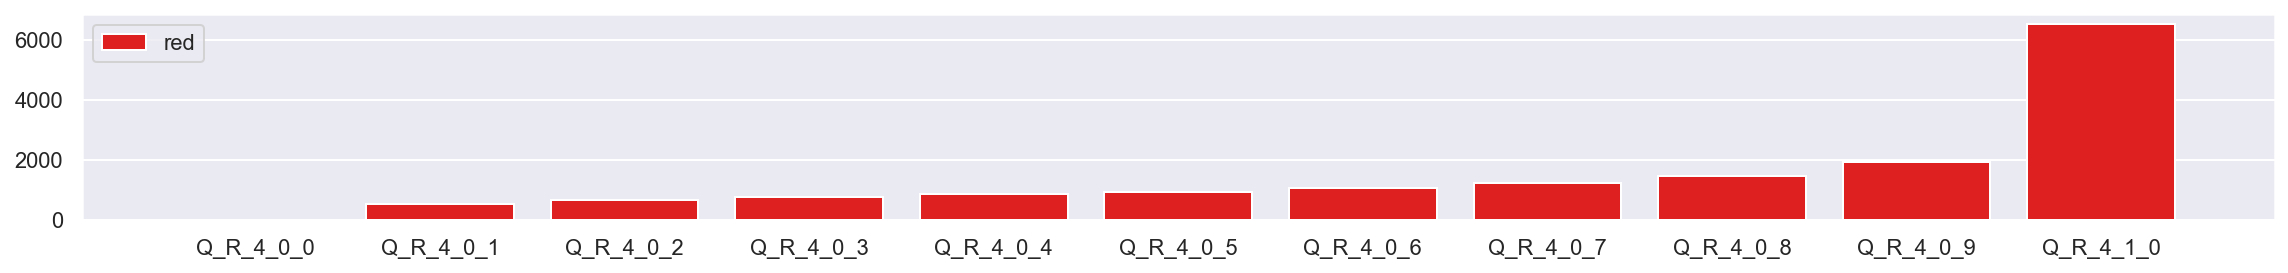

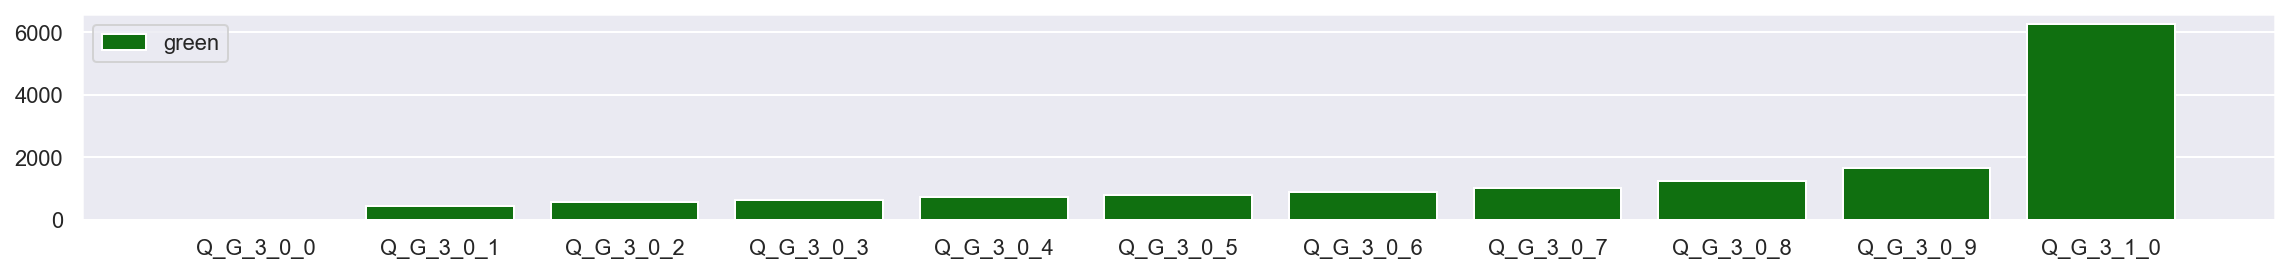

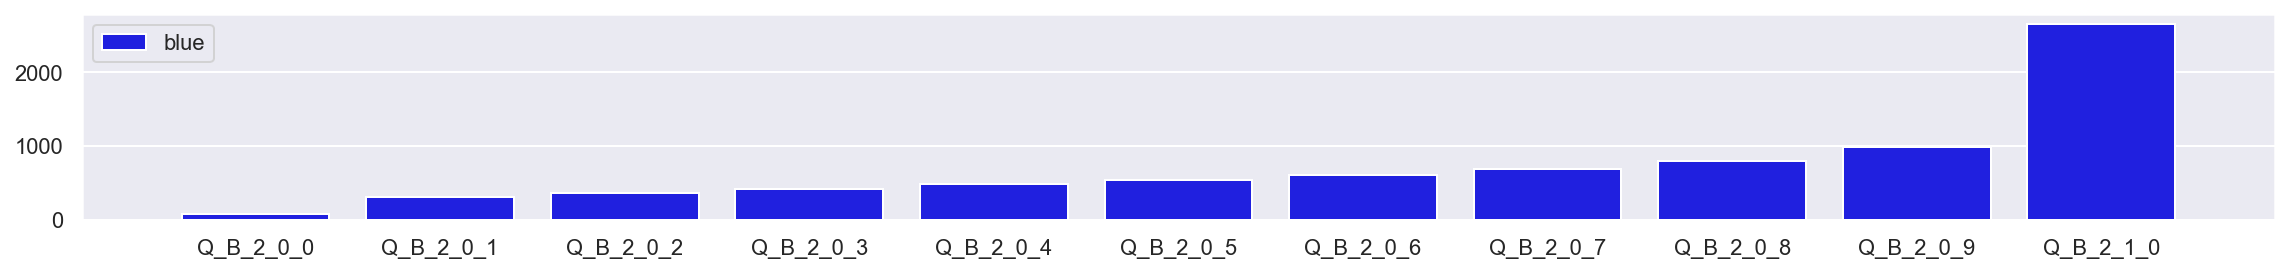

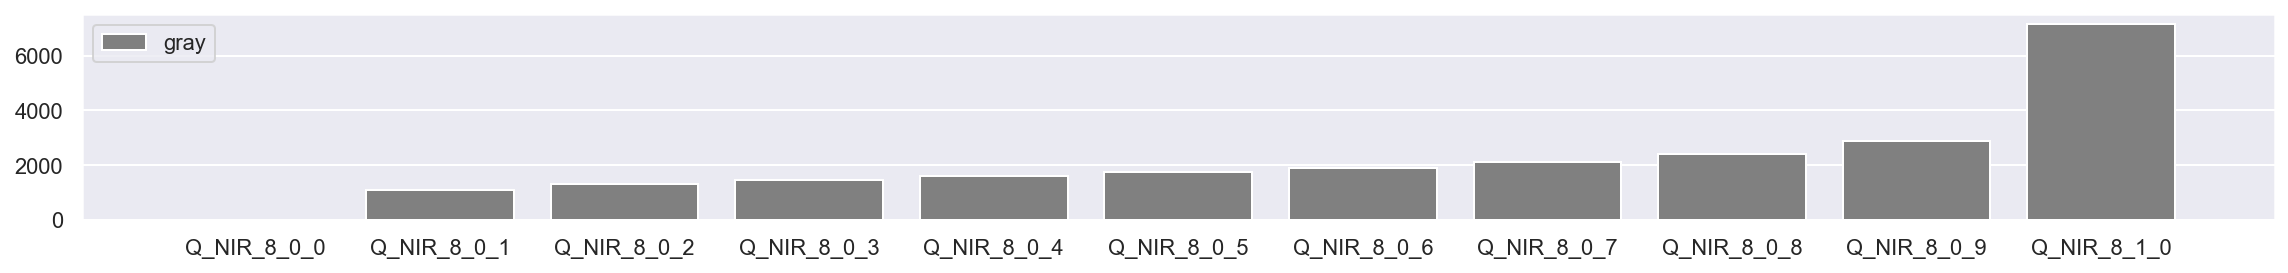

In [23]:
list_colors = [df_modelar.columns[2:13], df_modelar.columns[13:24], df_modelar.columns[24:35], df_modelar.columns[35:46]]
colors = [ 'red', 'green', 'blue', 'gray']
for idx, val in enumerate(list_colors):
    plt.figure(idx, figsize=(16,2))
    sns.barplot(x=df_modelar.iloc[1][val].index, y=df_modelar.iloc[1][val].values, color=colors[idx], label=colors[idx])
    plt.legend()
    plt.plot()
    plt.tight_layout()

En esta gráfica podemos ver que los valores van creciendo progresivamente en función del decil en el cual se encuentran, por lo que descartamos que se trate de un histograma. Además, en el caso de ser un histograma, el valor total de la suma de las diferentes variables correspondientes a los colores debería de ser igual para cada uno de los distintos registros y en la siguiente celda se demuestra que eso no es realmente así.

In [24]:
df_red = df_modelar[df_modelar.columns[2:-42]]
df_green = df_modelar[df_modelar.columns[13:-31]]
df_blue = df_modelar[df_modelar.columns[24:-20]]
df_nir = df_modelar[df_modelar.columns[35:-9]]

df_sum = df_red.sum(axis=1) + df_green.sum(axis=1) + df_blue.sum(axis=1) + df_nir.sum(axis=1)
df_sum.head(10)

ID
32495F6F5B3D012D    57185.083984
F3DED6C32C3AF640    61590.267553
7B3EE36498F19B20    55129.237709
AAE6E75EF15C8FFE    51292.514396
5A4E48F0B5A2EF0B    66292.849478
AF732B6DE4C6F741    56642.575419
440F05FF1B219AEF    62157.982266
72C44A99F7F3DC3B    48231.298691
2ABAEE9B1015CD78    58378.170320
639246373C613E09    58633.451274
dtype: float64

In [25]:
def process_color(row):
    dict_colors = {}
    dict_colors['red'] = row[colors[:11]].sum()
    dict_colors['green'] = row[colors[11:22]].sum()
    dict_colors['blue'] = row[colors[22:33]].sum()
    dict_colors['nir'] = row[colors[33:44]].sum()
    color = max(dict_colors, key=dict_colors.get)
    return color

De todas formas hemos generado una función en la que, por cada registro nos asigne cual de los colores es el predominante para cada uno de los registros del conjunto de datos, para ver si obtenemos una buena discretización entre clases, y con ello, podemos aportarle mayor información a la hora de clasificar a los modelos que entrenemos. 

In [ ]:
df_aux = df.copy()# Hacemos una copia para no alterar el conjunto de datos a analizar
scaler = MinMaxScaler()
df_aux[colors] = scaler.fit_transform(df_aux[colors])# Hacemos una estandarización de los datos referidos a los colores
df_aux['color'] = df_aux.apply(process_color, axis=1)# Aplicamos la función previamente desarrollada
for idx, val in enumerate(['red', 'green', 'blue', 'nir']): # Visualizamos los datos obtenidos
    plt.figure(idx, figsize=(12,4))
    sns.countplot(df_aux[df_aux['color'] == val]['CLASE'], order=list_class_order, label=val, color=val if val != 'nir' else 'gray')
    plt.legend()
    plt.plot()
    plt.tight_layout()

Como podemos observar en las gráficas obtenidas, sigue sin haber una correcta discretización de clases entre los distintos colores, ya que la mayoría de ellos siguen perteneciendo a la clase mayoritaria, cuando no deberían, como es el caso del rojo o del verde, que deberían discritizar mejor para la clase agricultura según la información obtenida del satélite Sentinel II.

<a id="section313"></a>
#### <font color="#004D7F">3.1.3 Variables relativas a la Geometría</font>

Con respecto a estas variables no tenemos demasiada información, lo único que sabemos es que las métricas geométricas se encuentran generadas automáticamente, bajo el prefijo **GEOM** y la variable `AREA` que corresponde al tamaño de la parcela a clasificar, aunque no sabemos la medica en la cual está establecida esta variable.

Primeramente comprobamos si presenta o no valores perdidos. En este caso no presenta valores perdidos y por lo tanto no es realizar ningun tipo de análisis extra.

In [26]:
df_modelar[geom].isna().sum()[df_modelar[geom].isna().sum()>0]

Series([], dtype: int64)

In [27]:
df_modelar[geom].describe()

,AREA,GEOM_R1,GEOM_R2,GEOM_R3,GEOM_R4
count,87745.000000,87745.000000,87745.000000,87745.000000,87745.000000
mean,439.223890,0.563416,0.062546,0.061902,1.074256
std,1872.237668,0.174034,0.042539,0.042506,0.549986
min,0.062300,0.000626,0.000840,0.000907,0.083703
25%,97.425800,0.455301,0.038256,0.038153,0.801567
50%,171.524750,0.536316,0.055804,0.055096,0.996952
75%,344.097428,0.675113,0.078493,0.078067,1.222981
max,238058.952253,1.000000,1.308044,2.631579,68.812431


En este caso podemos observar que existe una gran diferencia entre los valores máximos y mínimos, por lo que vamos a mostrar diagrama de cajas para observar esta varianza y comprobar si es correcta.
En el siguiente diagrama de cajas observamos que los datos se encuentran demasiado alejados de la media y la mediana, por lo tanto, creemos que podrían ser **outliers**, y sería conveniente realizar un estudio más en profundidad para que en el caso de que sean outliers, decidir si se eliminan o no, ya que pueden aportar ruido al modelo cuando éste sea entrenado con el conjunto de datos.

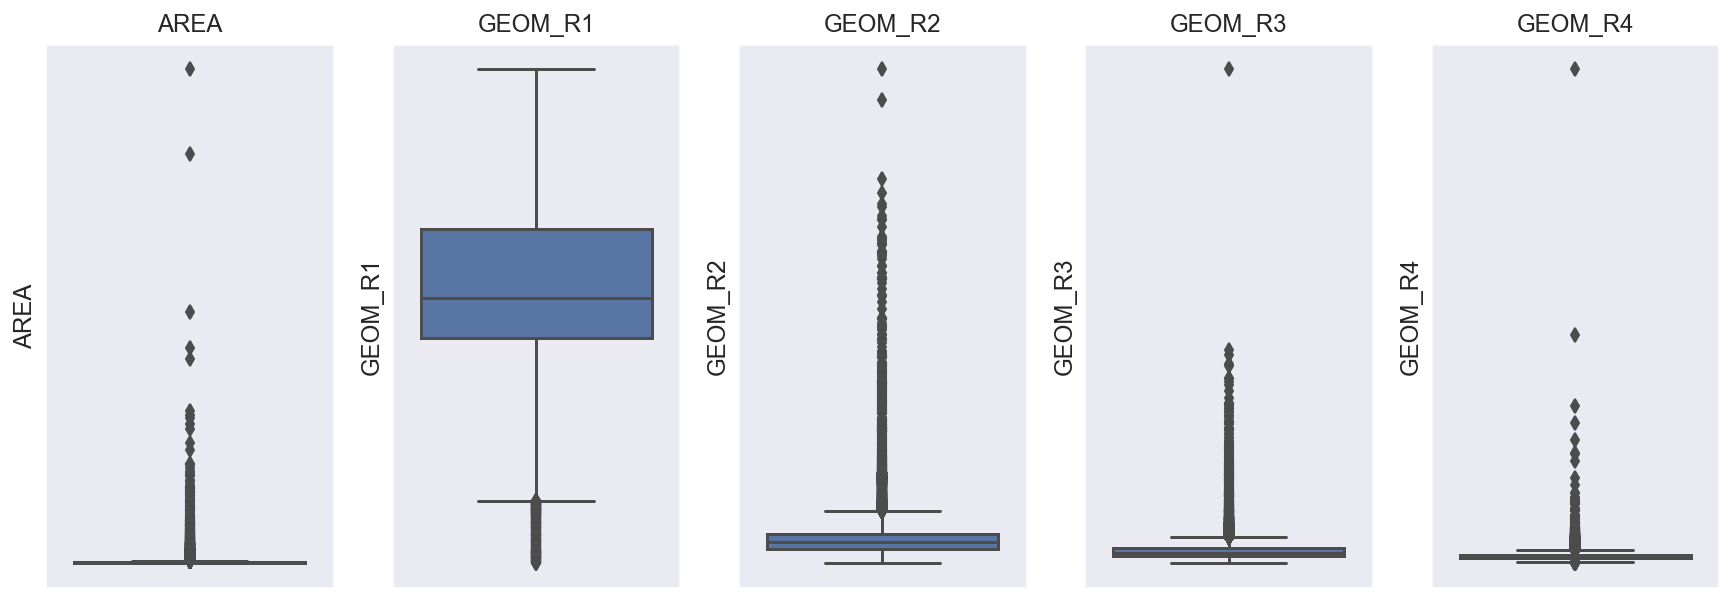

In [28]:
fig, axs = plt.subplots(1, 5, figsize=(15, 5))
for col, ax in enumerate(axs.flatten()):
    col_name = geom[col]
    sns.boxplot(x=df_modelar[col_name], orient='vertical', ax=ax)
    ax.set_title(col_name);    
    ax.set_yticks([])

Vamos a sacar los 100 elementos cuya area sea mayor que el resto para ver de que tipo de suelo son y por lo tanto poder concluir si se trata de outliers o no.

In [29]:
df_modelar.loc[df_modelar['AREA'].nlargest(100).index.tolist()]['CLASE'].value_counts()

OTHER          35
INDUSTRIAL     26
PUBLIC         20
RETAIL         12
OFFICE          4
RESIDENTIAL     2
AGRICULTURE     1
Name: CLASE, dtype: int64

Observamos que una de las clases minoritarias es `RESIDENTIAL`, por lo tanto, al ser la clase predominante en el problema hay que analizar estos valores con respecto a cada clase, no sólo sobre la variabe `AREA`.

In [30]:
df_modelar.groupby('CLASE')['AREA'].describe()

,count,mean,std,min,25%,50%,75%,max
CLASE,,,,,,,,
AGRICULTURE,287.0,942.853648,6160.929527,7.966000,99.806425,230.237485,619.368850,103410.248537
INDUSTRIAL,3816.0,1122.819918,3401.532514,0.999651,128.246636,348.396063,873.442389,98047.398600
OFFICE,1554.0,1465.935544,2418.649416,3.835600,349.760995,750.369419,1525.709862,33067.414650
OTHER,1132.0,3105.338393,7491.919878,0.062300,165.351979,858.272811,2758.748027,120836.394036
PUBLIC,2530.0,1817.154631,3363.776914,1.221721,338.533928,894.853157,1954.421413,54270.868307
RESIDENTIAL,76647.0,281.169801,481.426944,0.168230,93.959290,158.265150,297.299118,33948.641804
RETAIL,1779.0,1148.336450,8023.787071,2.890800,99.829265,265.060395,749.200255,238058.952253


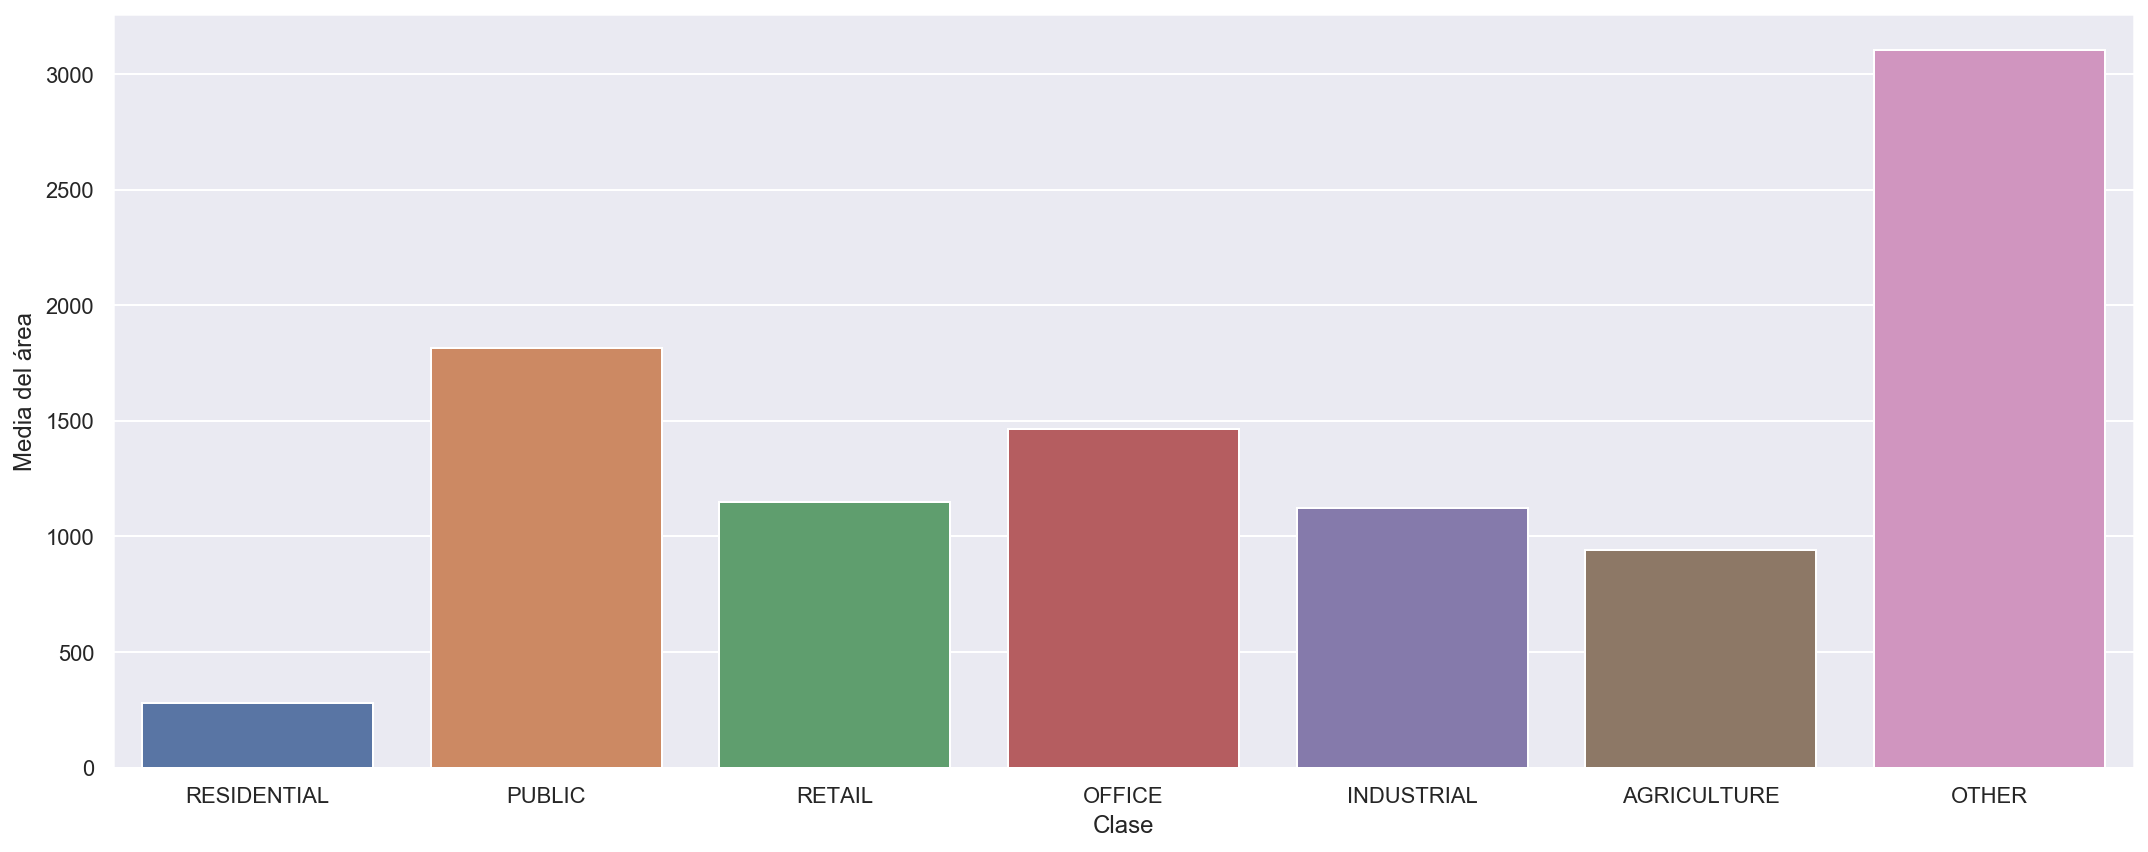

In [31]:
plt.figure(figsize=(15,6))
sns.barplot(x=df_modelar.groupby('CLASE')['AREA'].mean().index.values, y=df_modelar.groupby('CLASE')['AREA'].mean().values, order=list_class_order)
plt.xlabel('Clase')
plt.ylabel('Media del área')
plt.tight_layout()

En este gráfico se puede observar como la variable `RESIDENTIAL` que es la mayoritaría en nuestro conjunto de datos, presenta un área media menor en comparación con el resto de clases a clasificar, siendo esta **281** aproximadamente. Esto nos puede dar una idea del tamaño de cada uno de los terrenos clasificados como `RESIDENTIAL` y se puede comprobar que representan un menor tamaño que el resto.

Esto provoca que al haber mayor número de registros con esta media, el resto de valores del resto de clases se muestren como outliers en el diagrama de cajas previamente visualizado, cuando no tiene porqué serlo.

De todas formas vamos a realizar un estudio en mayor profundidad eliminando aquellos registros que "*suponemos*" que son outliers. Para ello se ha implementado una función denominada _delete_outliers_geom_ que tiene como finalidad la eliminación de estos supuestos _outliers_ mediante los quartiles, independientes para cada una de las variables.

In [32]:
def delete_outliers_geom(df, columns):
    df_aux = df.copy()
    for col_name in columns:
        if col_name == 'AREA':
            third_quantile_area = df_aux[col_name].quantile(0.8)
            df_aux = df_aux[df_aux[col_name] < third_quantile_area]
        elif col_name == 'GEOM_R1':
            first_quantile_area = df_aux[col_name].quantile(0.016)
            third_quantile_area = df_aux[col_name].quantile(0.92)
            df_aux = df_aux[(df_aux[col_name] > first_quantile_area) & (df_aux[col_name] < third_quantile_area)]
        elif col_name == 'GEOM_R2':
            third_quantile_area = df_aux[col_name].quantile(0.96)
            df_aux = df_aux[df_aux[col_name] < third_quantile_area]
        elif col_name == 'GEOM_R3':
            third_quantile_area = df_aux[col_name].quantile(0.96)
            df_aux = df_aux[df_aux[col_name] < third_quantile_area]
        elif col_name == 'GEOM_R4':
            third_quantile_area = df_aux[col_name].quantile(0.93)
            first_quantile_area = df_aux[col_name].quantile(0.005)
            df_aux = df_aux[(df_aux[col_name] > first_quantile_area) & (df_aux[col_name] < third_quantile_area)]
    return df_aux

Aplicamos la función previamente implementada y almacenamos el resultado en un _dataframe_ auxiliar para no modificar el original.

In [33]:
df_aux = delete_outliers_geom(df_modelar, geom)

Después de aplicar una eliminación de los supuestos outliers obtenemos los siguientes diagramas de cajas sin outliers:

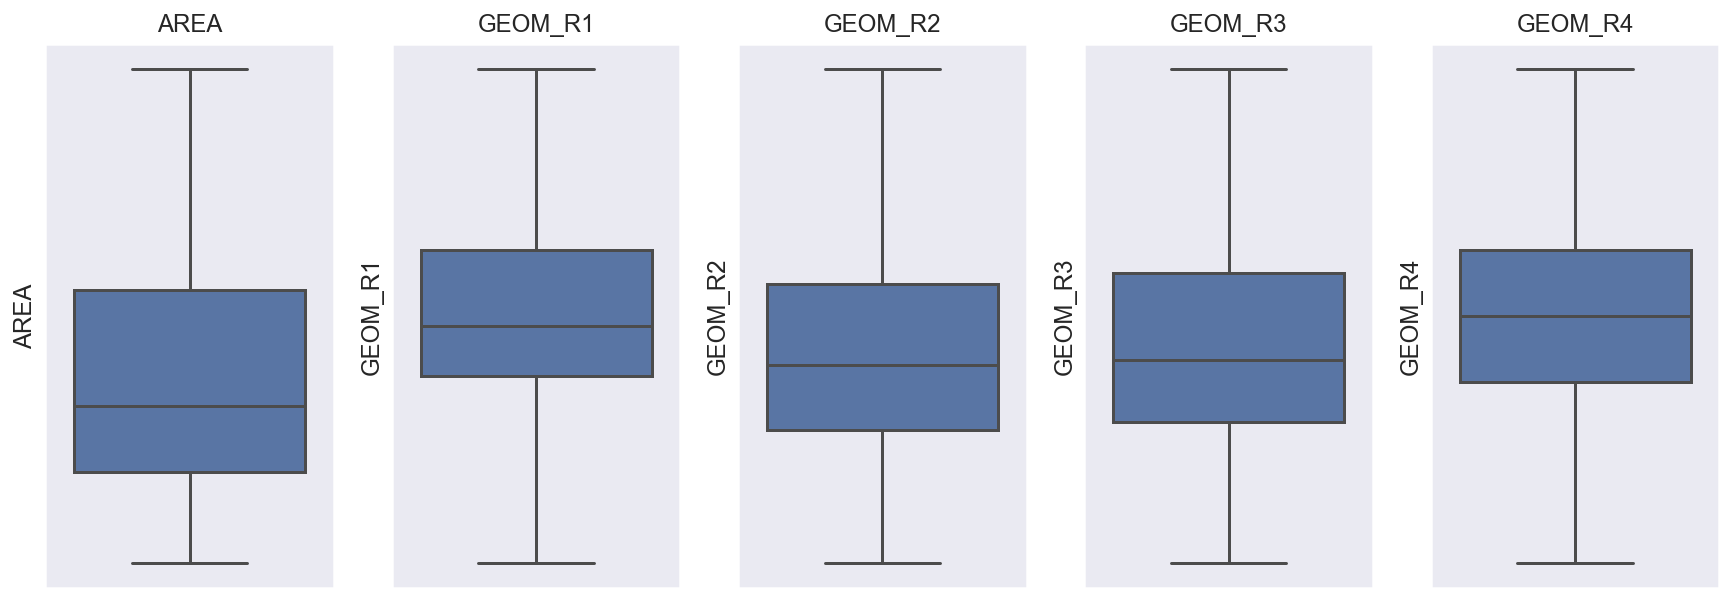

In [34]:
fig, axs = plt.subplots(1, 5, figsize=(15, 5))
for col, ax in enumerate(axs.flatten()):
    col_name = geom[col]
    sns.boxplot(x=df_aux[col_name], orient='vertical', ax=ax)
    ax.set_title(col_name);    
    ax.set_yticks([])

In [35]:
print(f"Dataset con outliers: {df_modelar.shape}")
print(f"Dataset sin outliers: {df_aux.shape}")

Dataset con outliers: (87745, 55)
Dataset sin outliers: (54093, 55)


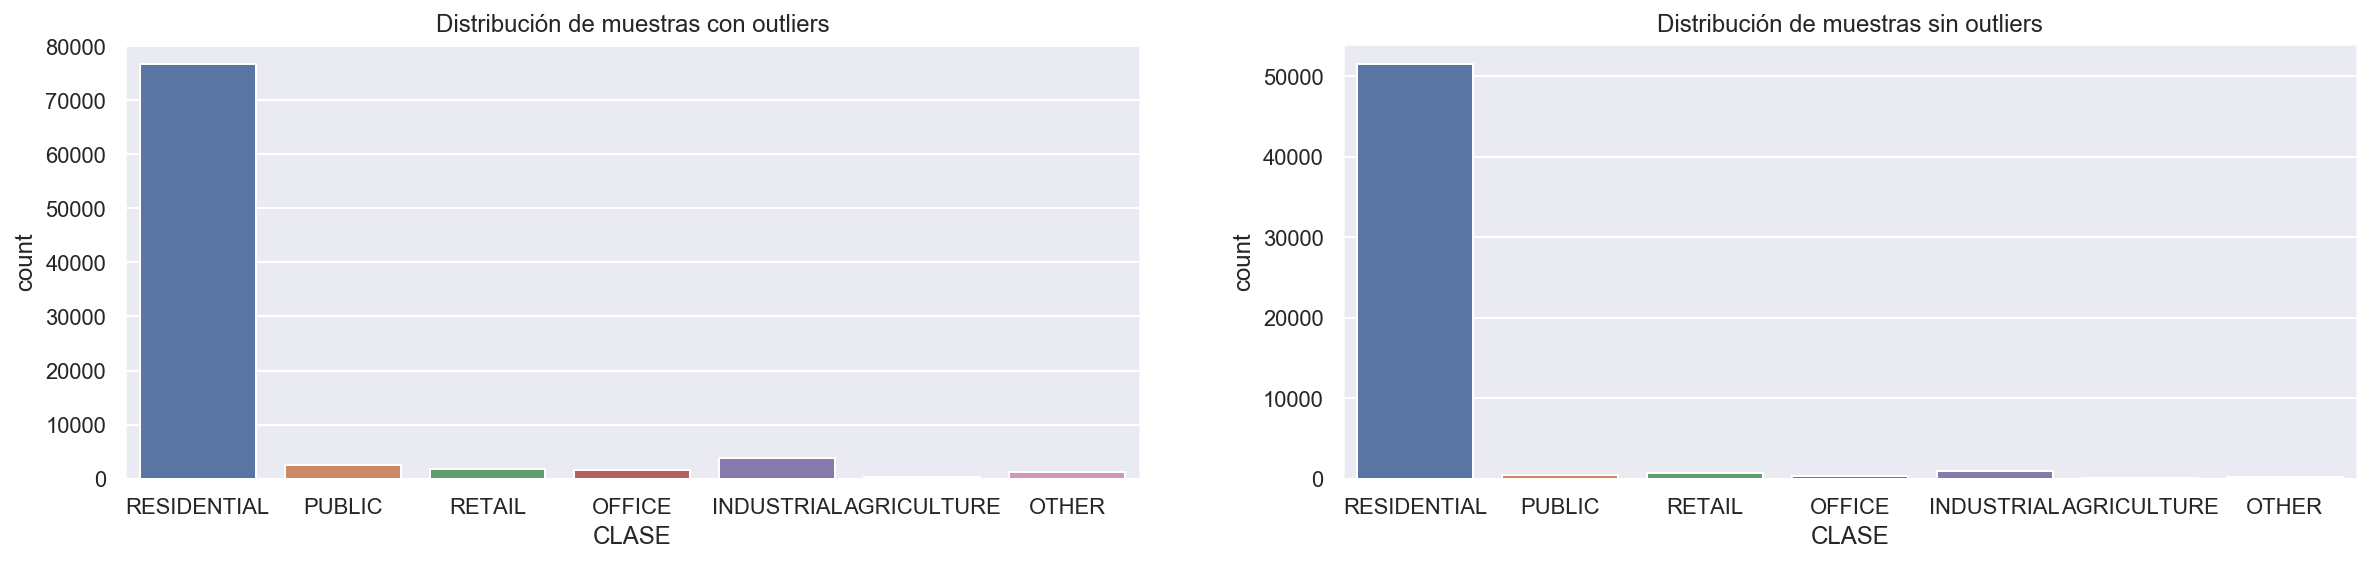

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,4))
sns.countplot(x='CLASE', data=df_modelar, order=list_class_order, ax=ax1)
ax1.set_title('Distribución de muestras con outliers')
sns.countplot(x='CLASE', data=df_aux, order=list_class_order, ax=ax2);
ax2.set_title('Distribución de muestras sin outliers');

La eliminación de outliers reduce considerablemente el número de registros de nuestro conjunto de datos y es por ello por lo que debemos de valorar si se deben de eliminar o no estos outliers, o si realmente se trata de outliers o no. 

Consideramos que al haber reducido el conjunto de datos original en casi un 50% y en haber perjudicado las clases minoritarias, vamos seguir trabajando con el conjunto de datos original sin eliminar los supuestos outliers, y aceptamos que se tratan de valores normales. Preferimos mantener los registros referentes a las clases minoritarias, a reducir el conjunto de datos eliminando estos registros.

Las variables geométricas parecen tener una gran importancia en nuestro conjunto de datos, por lo que es conveniente seguir realizando un análisis exahustivo de ellas:

In [37]:
df_modelar.groupby('CONTRUCTIONYEAR')[['AREA']].mean().nlargest(10, 'AREA')

,AREA
CONTRUCTIONYEAR,
2012,1637.784682
2015,1036.504774
1899,1005.173843
1985,745.961769
2011,736.877004
2013,720.609889
1971,663.542176
1863,656.624418
1983,644.865187


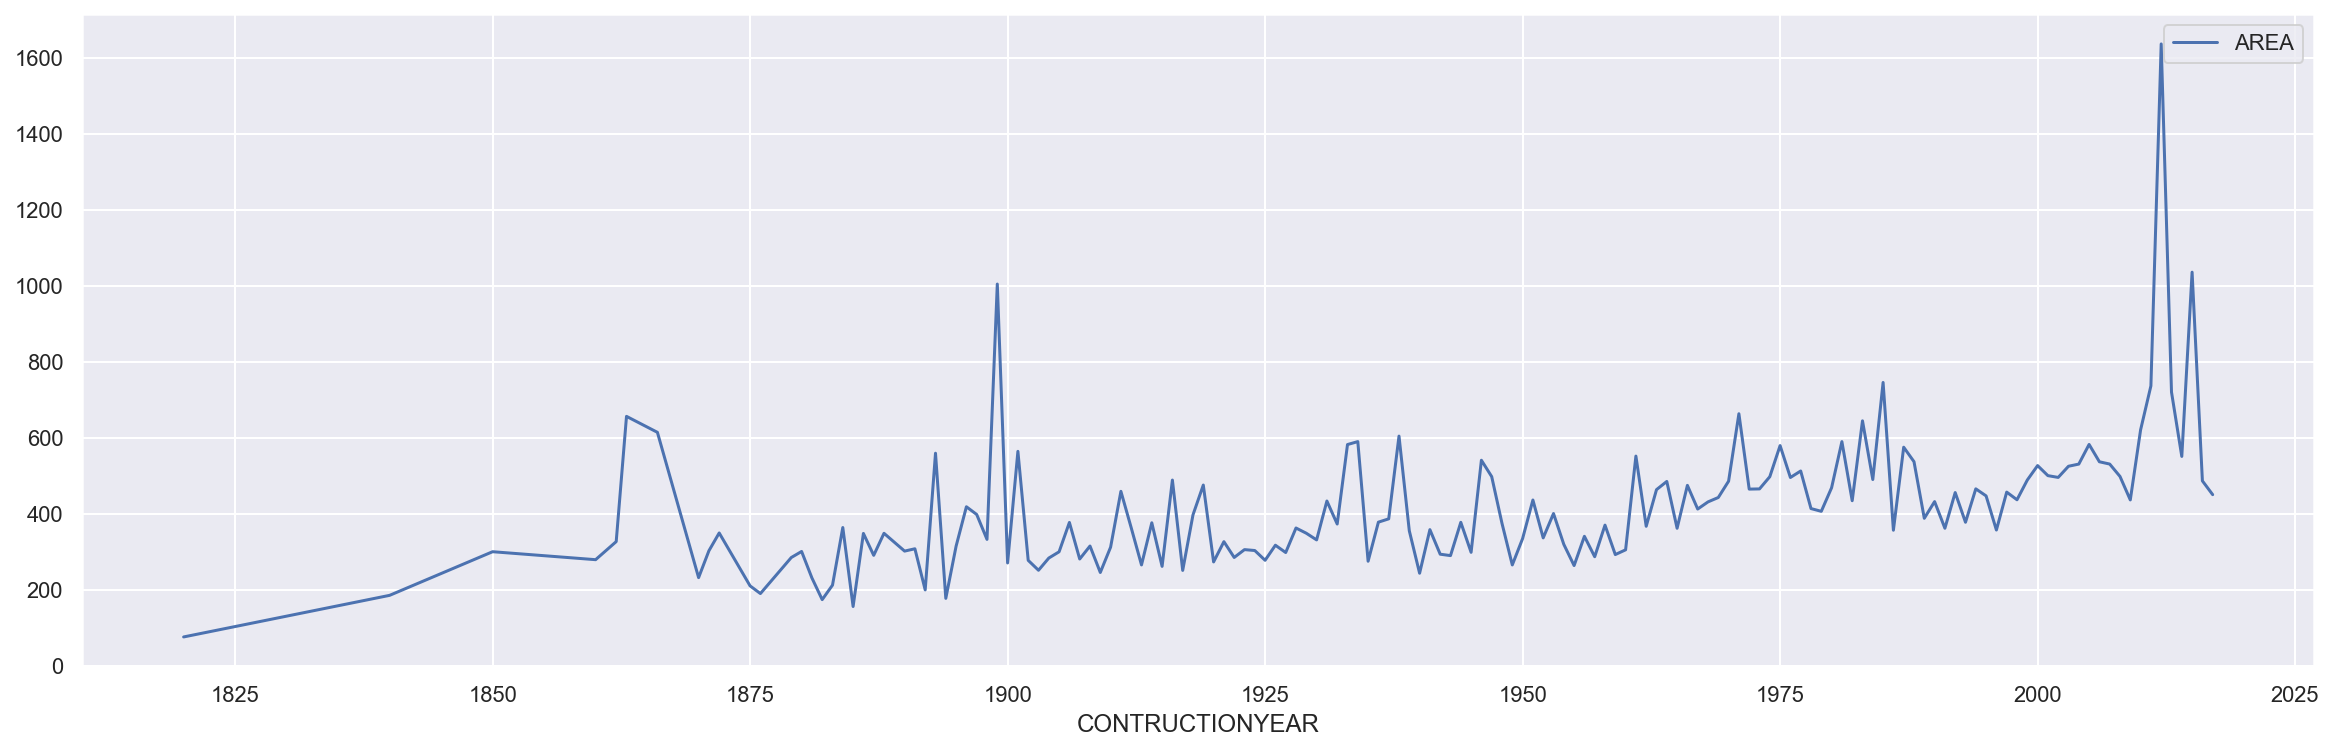

In [38]:
plt.figure(figsize=(20,6))
sns.lineplot(data=df_modelar.groupby('CONTRUCTIONYEAR')[['AREA']].mean());

En esta gráfica se aprecia un pequeño aumento de la media del área conforme avanzan los años y llegamos a la actualidad o a los datos más reciente.

<a id="section314"></a>
#### <font color="#004D7F">Variables relativas al año de construcción y máximo de pisos de los edificios colindantes</font>

Primeramente comprobamos si presentan o no valores perdidos. En este caso si presenta valores perdidos y por lo tanto es conveniente realizar un análisis extra.

In [39]:
df_modelar[others].isna().sum()

CONTRUCTIONYEAR      0
MAXBUILDINGFLOOR    19
dtype: int64

Si ahora realizamos una comprobación del conjunto de datos completo podemos observar que hay otra variable discreta que también presenta valores perdidos:

In [40]:
df_modelar.isna().sum()[df_modelar.isna().sum()>0]

MAXBUILDINGFLOOR      19
CADASTRALQUALITYID    19
dtype: int64

In [41]:
df_modelar[df_modelar.isna().any(axis=1)]

,X,Y,Q_R_4_0_0,Q_R_4_0_1,Q_R_4_0_2,Q_R_4_0_3,Q_R_4_0_4,Q_R_4_0_5,Q_R_4_0_6,Q_R_4_0_7,...,Q_NIR_8_1_0,AREA,GEOM_R1,GEOM_R2,GEOM_R3,GEOM_R4,CONTRUCTIONYEAR,MAXBUILDINGFLOOR,CADASTRALQUALITYID,CLASE
ID,,,,,,,,,,,,,,,,,,,,,
621448B2B12E3B3E,2233865202,165097257,0.000009,609.998492,778.999695,889.001544,976.000098,1068.000366,1169.998853,1271.998901,...,5208.317414,710.658165,0.115690,0.014473,0.011248,0.777191,1950,NaN,NaN,AGRICULTURE
82489ECC7BDFB0B0,2250087048,165252257,0.000000,648.000018,788.999866,894.999255,987.001318,1079.999817,1184.999121,1317.997363,...,6084.405066,1829.160728,0.153173,0.009619,0.008705,0.905010,1975,NaN,NaN,RETAIL
2CC4B745CE79E7C7,2238737866,165233240,0.003241,732.000824,846.999390,929.000122,1006.999573,1091.998230,1190.000000,1307.998840,...,6525.757126,265.335000,0.453691,0.046970,0.036403,0.775027,1966,NaN,NaN,INDUSTRIAL
99C000CA552F2F1A,2246109269,165175274,0.000760,641.000610,764.999939,875.999817,990.000061,1116.992004,1286.000854,1513.999695,...,7712.102151,719.815650,0.299387,0.015946,0.026082,1.635629,1966,NaN,NaN,AGRICULTURE
41FB599E9B4816A8,2246888671,165177534,0.000760,641.000610,764.999939,875.999817,990.000061,1116.992004,1286.000854,1513.999695,...,7712.102151,958.381450,0.218652,0.008562,0.026645,3.111910,1966,NaN,NaN,AGRICULTURE
51DCB5C9945A826E,2239496952,165148413,0.000006,493.999994,610.000061,687.999243,754.999768,824.999542,912.000513,1027.999646,...,5270.232234,88.353700,0.469356,0.068634,0.077399,1.127709,1957,NaN,NaN,AGRICULTURE
5D08956CDC0B7C37,2250193143,165232359,0.000000,648.000018,788.999866,894.999255,987.001318,1079.999817,1184.999121,1317.997363,...,6084.405066,1999.778850,0.531552,0.016810,0.015813,0.940702,1975,NaN,NaN,AGRICULTURE
D715EFB7AB240B96,2257571528,165116729,0.000004,437.000958,597.003247,711.998651,806.999329,910.999084,1039.000195,1183.999719,...,5922.090811,50.010750,0.532060,0.118624,0.089686,0.756054,1982,NaN,NaN,AGRICULTURE
B4A58FDBD97DA74B,2255636575,165095665,0.000004,437.000958,597.003247,711.998651,806.999329,910.999084,1039.000195,1183.999719,...,5922.090811,1083.745180,0.152886,0.008717,0.016184,1.856596,1975,NaN,NaN,AGRICULTURE


Vemos que en realidad estos 40 valores perdidos corresponden unicamente con 19 registros de nuestro conjunto de datos, ya que casualmente los valores perdidos se presentan de forma simultánea tanto en la variable `CONTRUCTIONYEAR` como `MAXBUILDINGFLOOR`. Dado los valores perdidos pertenecen a las clases más desbalanceadas de nuestro conjunto se debe de tomar la decisión de qué hacer con los valores perdidos. 

También se debe de tener en cuenta que la variable `CONTRUCTIONYEAR` tiene un orden que indica la calidad del terreno, por lo que no podríamos establecer cualquier valor. Esta decisión se resolverá más adelante.

Como información adicional, se realiza una gráfica interactiva para visualizar el número de registros de cada clase en función del año de construcción de los edificios colindantes.

In [42]:
def plot_year_class(Year=2017):
    plt.figure(figsize=(15,10))
    sns.countplot(df_modelar[df_modelar['CONTRUCTIONYEAR']==Year]['CONTRUCTIONYEAR'], hue=df_modelar['CLASE'])
    plt.ylabel('Number')
    plt.show()
    print(f'-----------Year {Year}---------')
    print(df_modelar[df_modelar['CONTRUCTIONYEAR']==Year]['CLASE'].value_counts())

In [43]:
interact(plot_year_class,
         Year = np.sort(df_modelar['CONTRUCTIONYEAR'].unique()));

interactive(children=(Dropdown(description='Year', index=149, options=(1820, 1840, 1850, 1860, 1862, 1863, 186…

In [44]:
df_group_year = df_modelar.groupby('CONTRUCTIONYEAR')['CLASE'].value_counts().unstack()

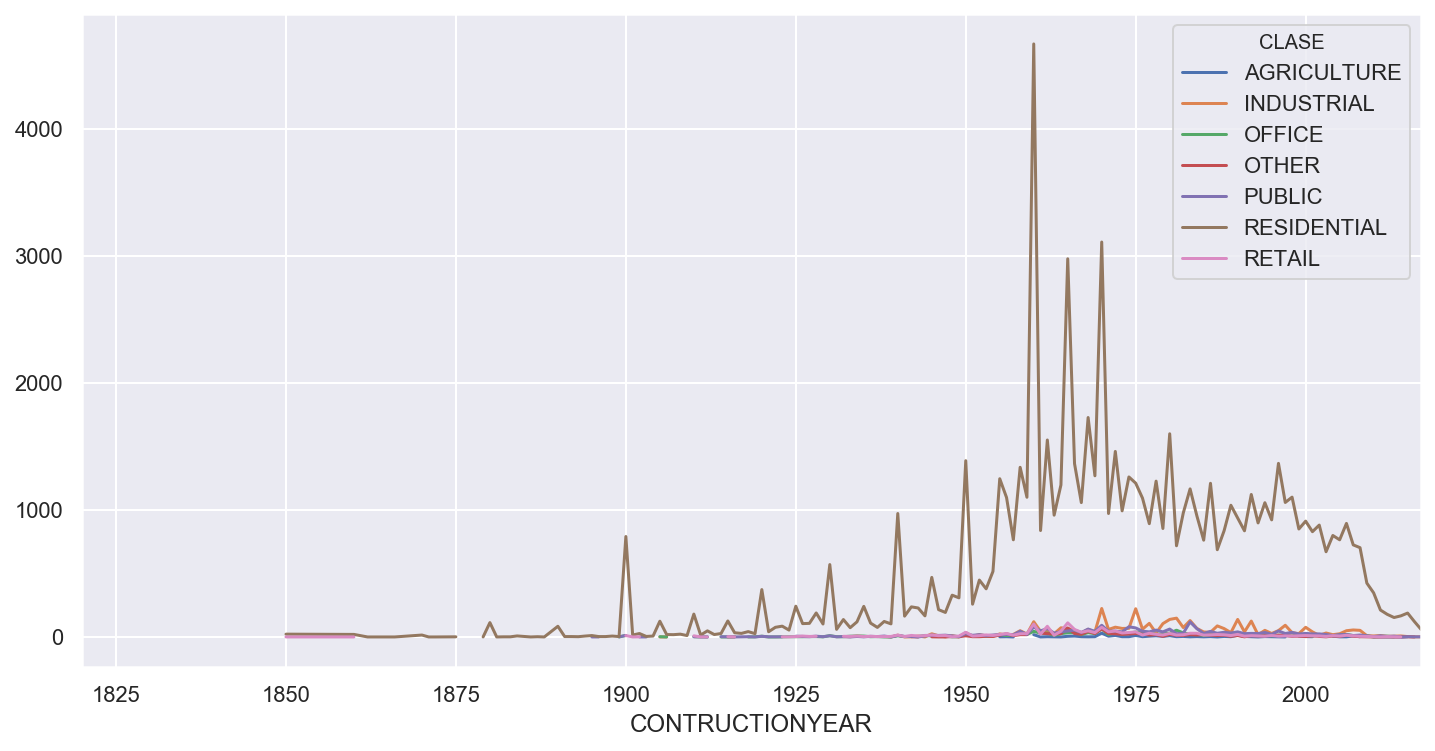

In [45]:
fig, ax = plt.subplots(figsize=(12,6))
df_group_year.plot(ax=ax);

Nos centramos en aquellas clases que son menos predominantes, ya que como el problema está desbalanceado, la clase `RESIDENTIAL` es predominante.
En la siguiente gráfica observamos que entre los años 1925 y 2017 los edificios predominantes son aquellos que presentan la clase `INDUSTRIAL` y `PUBLIC`.

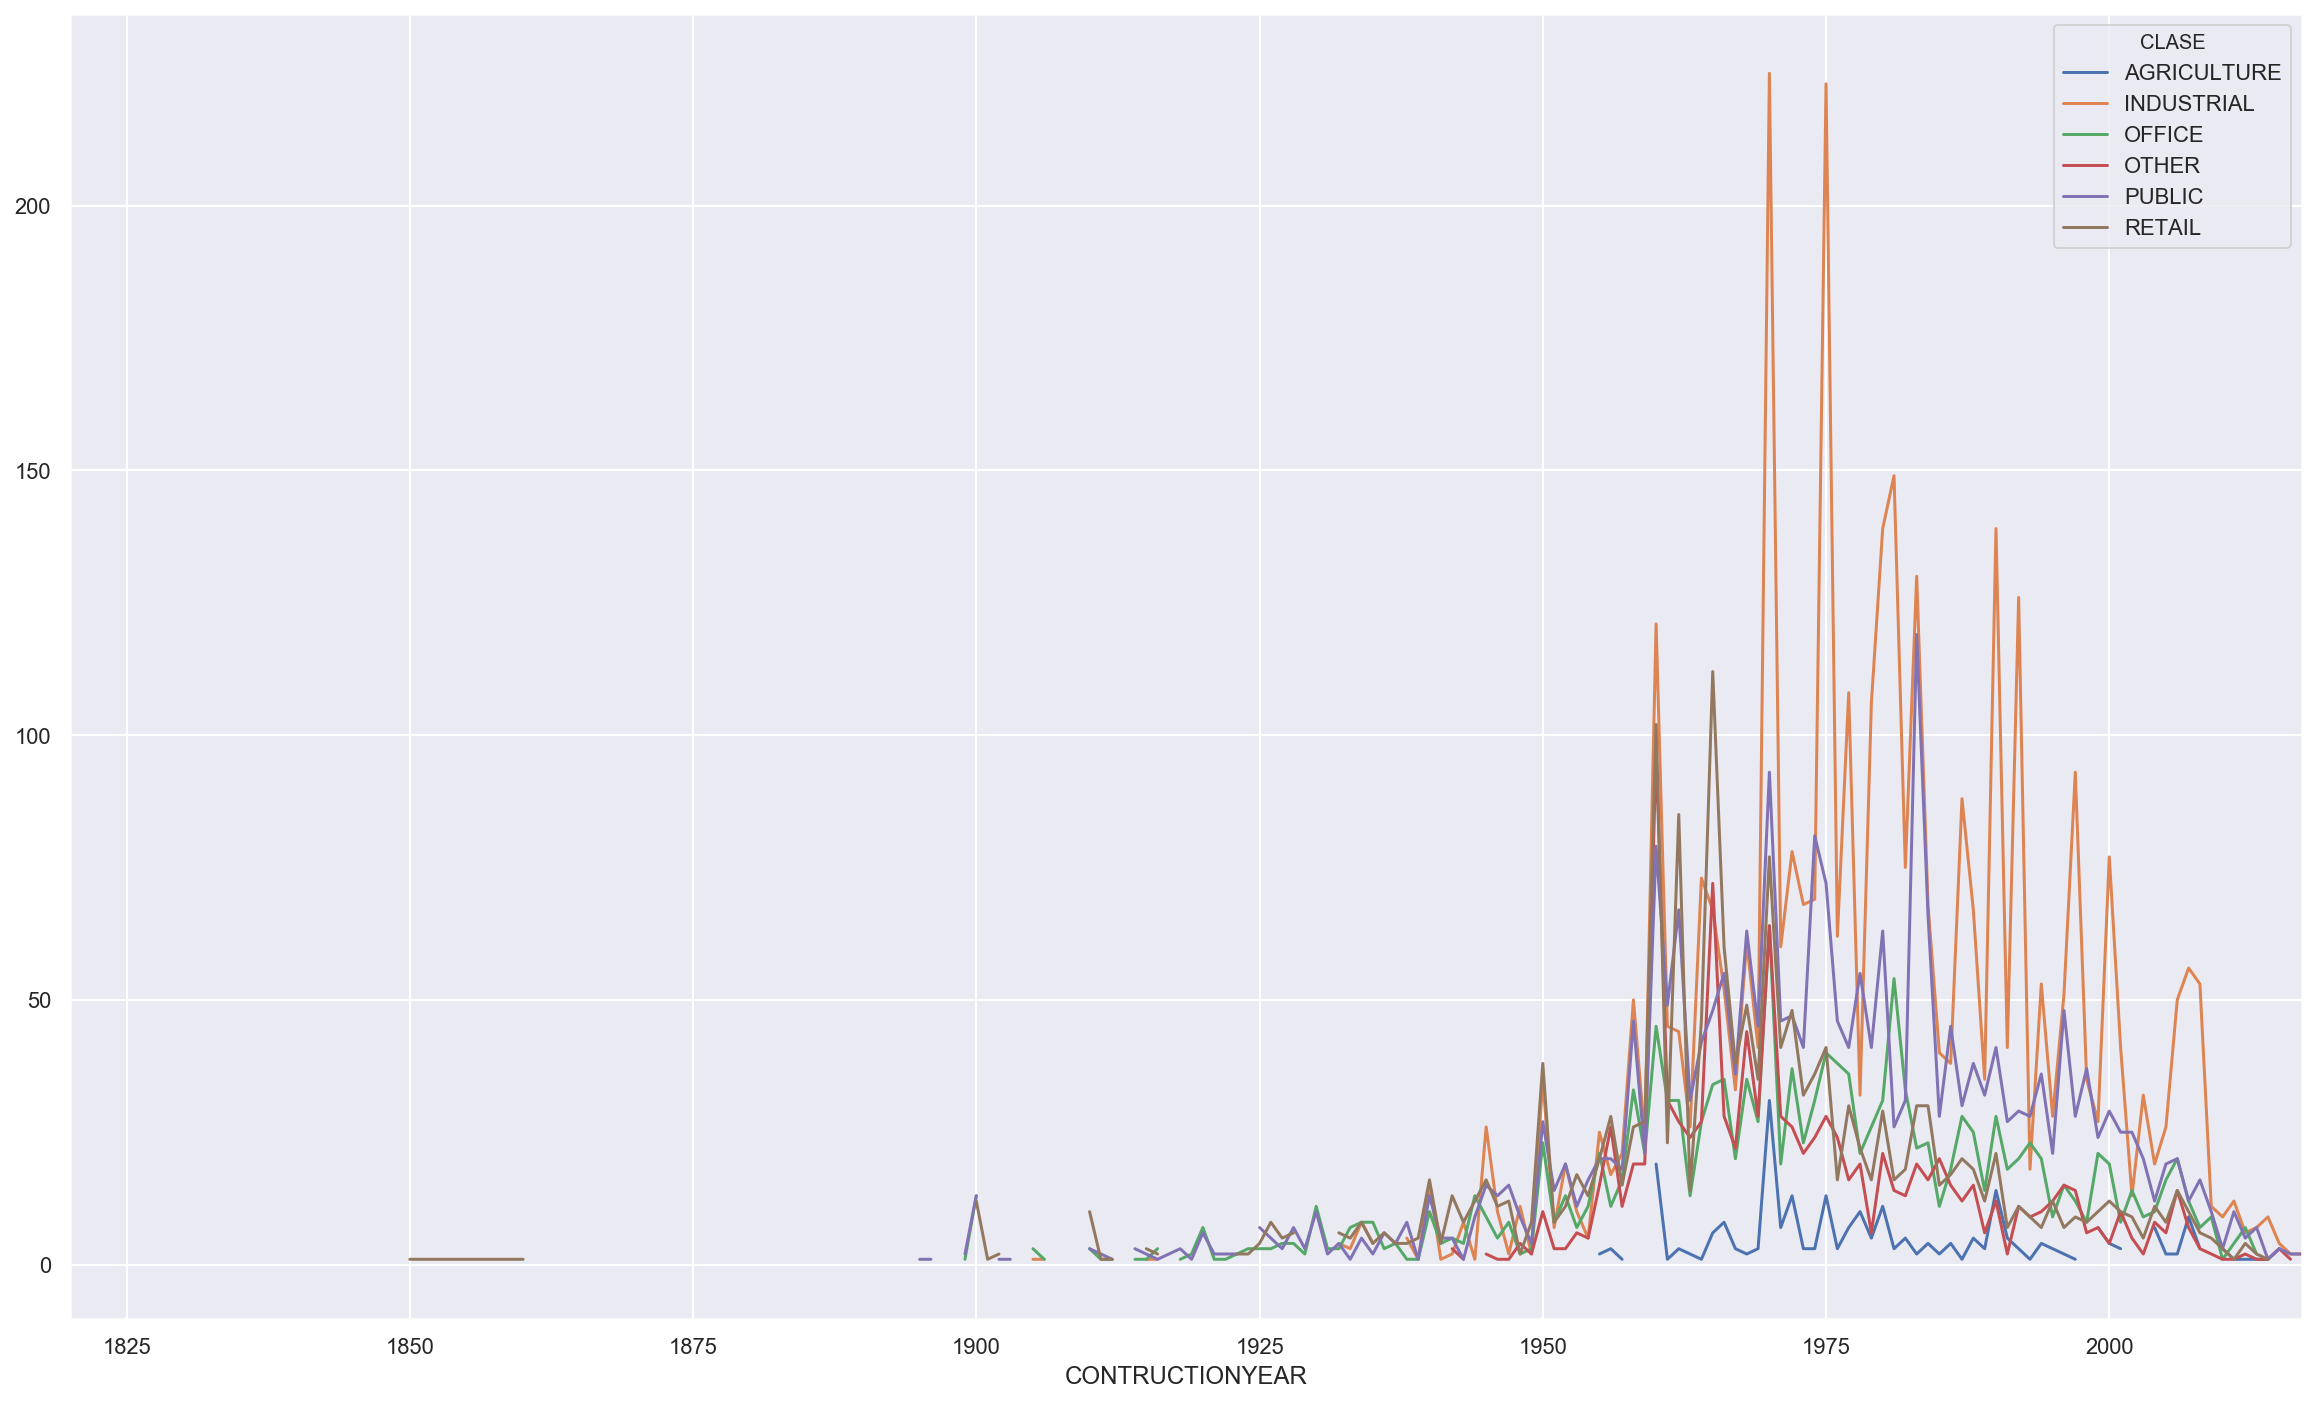

In [46]:
classes = df_group_year.columns.tolist()[0:-2]
classes.append('RETAIL')
fig, ax = plt.subplots(figsize=(20,12))
df_group_year[classes].plot(ax=ax);

En cuanto a la variable restante de este grupo, `MAXBUILDINGFLOOR` sabemos que hace referencia a la altura máxima de los registros colindantes al terreno en cuestión y no al propio. De todas formas realizamos un análisis de la misma para conocer un poco más sobre ella y obtener algunos datos que nos puedan otorgar información adicional al problema.

In [47]:
print("Diferentes valores de la variable: \n", df_modelar['MAXBUILDINGFLOOR'].unique())
print("Total: ", len(df_modelar['MAXBUILDINGFLOOR'].unique()))

Diferentes valores de la variable: 
 [ 3.  2.  6.  5.  1.  7.  8.  4. 14. 10.  0.  9. 11. 16. 15. 13. 21. 23.
 12. 17. 22. 18. 25. nan 19. 24. 20.]
Total:  27


Vemos que presenta un <b>total de 27 valores distintos</b> esta variable, en los cuales se incluyen también los valores perdidos ya que por el momento no han sido tratados y se hará más adelante.

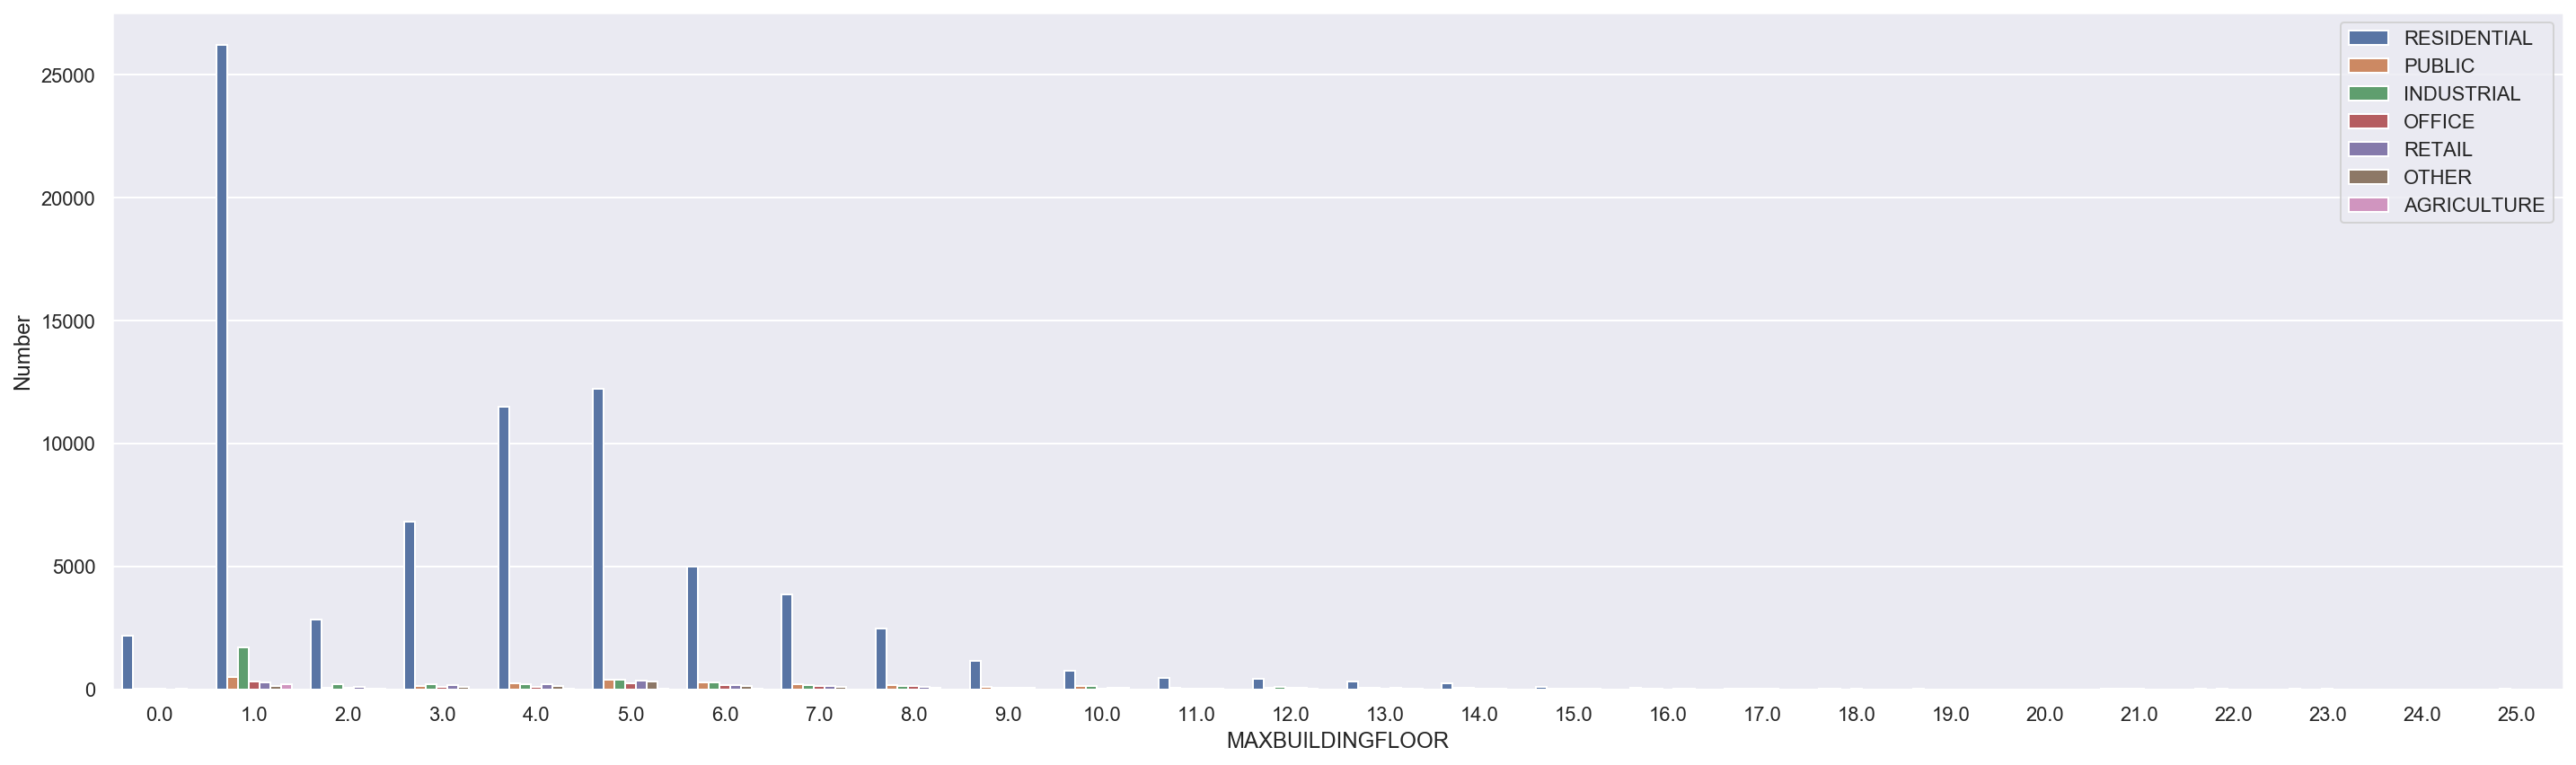

In [48]:
plt.figure(figsize=(20,6))
sns.countplot(x='MAXBUILDINGFLOOR', data=df_modelar, hue='CLASE')
plt.ylabel('Number')
plt.tight_layout()
plt.legend(loc=1);

Como resulta imposible realizar un análisi de esta variable mediante este tipo de gráficos debido a la gran diferencia que existe entre sus valores y la variable objetivo, se ha optado por realizar un gráfico interactivo que nos permita entrar más en detalle en cada caso.

In [ ]:
def plot_floor_class(Floor=1):
    plt.figure(figsize=(15,8))
    sns.countplot(df_modelar[df_modelar['MAXBUILDINGFLOOR']==Floor]['MAXBUILDINGFLOOR'], hue=df_modelar['CLASE'])
    plt.ylabel('Number')
    plt.show()
    print(f'-----------Floor {Floor}---------')
    print(df_modelar[df_modelar['MAXBUILDINGFLOOR']==Floor]['CLASE'].value_counts())

In [ ]:
interact(plot_floor_class,
         Floor = np.sort(df_modelar['MAXBUILDINGFLOOR'].unique())[:-1]);

In [ ]:
#Información relativa al valor perdido con respecto a la variable MAXBUILDINGFLOOR
sns.countplot(x='CLASE', data=df_modelar[df_modelar['MAXBUILDINGFLOOR'].isna()])
plt.ylabel('Number');
print(f'-----------Floor NaN---------')
print(df_modelar[df_modelar['MAXBUILDINGFLOOR'].isna()]['CLASE'].value_counts())

En esta gráfica podemos ver la clasificación que obtienen los registros en los cuales nos encontramos con un valor perdido en la variable `MAXBUILDINGFLOOR`. Como se obserca, 15 de ellos pertenecen a la clase minoritaria del conjunto de datos `AGRICULTURE` y el resto a `INDUSTRIAL` y `RETAIL`.

---

<a id="section32"></a>
### <font color="#004D7F">3.2 Tratamiento de las columnas discretas </font>


En relación a estas columnas, dos aspectos muy relevantes de cara a la construcción de un modelo con `scikit-learn` son: el número de valores que puede tomar cada una; y si existe una relación de orden entre estos valores. Estos factores determinan el tipo de transformación que se ha de hacer. Existen cuatro posibilidades:

* Cuando la columna toma dos valores, se puede binarizar y convertir a numérica diréctamente. 
* Si el tamaño del conjunto de valores es mayor que dos, y no existe una relación de orden entre ellos, se aplica `One Hot Encoding` (se aplicará posteriormente en el `Pipeline` de transformaciones).
* Si existe una relación de orden, los valores se transforman a numéricos, sustituyendo cada valor por su orden. 
* Si el conjunto de valores extremadamente grande se ha de explorar, ya que es muy posible que se trate de un error.

In [49]:
# Recordar que la variable CLASE también es discreta pero se ha eliminado al ser la varible objetivo
num_values_dis_df_col = [(col, len(df_modelar[col].value_counts())) for col in dis_df_columns]
num_values_dis_df_col

[('CADASTRALQUALITYID', 12)]

De esta variable en concreto tenemos una información adicional y es que se trata de una variable categórica representativa de la calidad y que tiene un órden:

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> <b>MAYOR a MENOR CALIDAD: A > B > C > 1 > 2 > 3 >...> 8 > 9</b>
</div>

Por lo tanto, lo primero que debemos de hacer es establecer ese órden en estas variable en el conjunto de datos para el entrenamiento de los modelos.

In [50]:
def process_cadastralquality(value):
    dic = {'A': 11, 'B': 10, 'C': 9}
    if value in dic:
        return dic[value]
    else:
        try:
            return 9 - int(value)
        except ValueError:
            return np.nan
        
def process_cadastral(df):
    df['CADASTRALQUALITYID'] = df['CADASTRALQUALITYID'].apply(process_cadastralquality)

Esta función se aplicará para realizar el procesamiento de los datos con respecto a esta variable.

In [51]:
list_preprocess_function.append(process_cadastral)

Aún así vamos a analizar un poco que valores presenta y si nos aporta información relevante con respecto a la clase, sin el procesamiento previo,

In [52]:
df_modelar_aux = df_modelar.copy()
process_cadastral(df_modelar_aux)
df_modelar_aux['CADASTRALQUALITYID'].value_counts()

5.0     20997
3.0     20794
4.0     16566
2.0     11743
6.0      8683
1.0      4677
7.0      2529
0.0       930
8.0       555
9.0       183
10.0       37
11.0       32
Name: CADASTRALQUALITYID, dtype: int64

Podemos observar que la mayoría de registros se encuentran condensados entre el identificador catastral 3 y 5, teníendo entre los dos aproximadamente 41000 registros. Mientras que los identificadores que representan mayor calidad como son 9, 10 y 11 (C, B, A), son los que presentan menor cantidad de registros. Por lo que, como podiamos esperar desde un principio, los datos se ajustan así mismo. Esto se puede ver de una manera más sencilla en el siguiente gráfico:

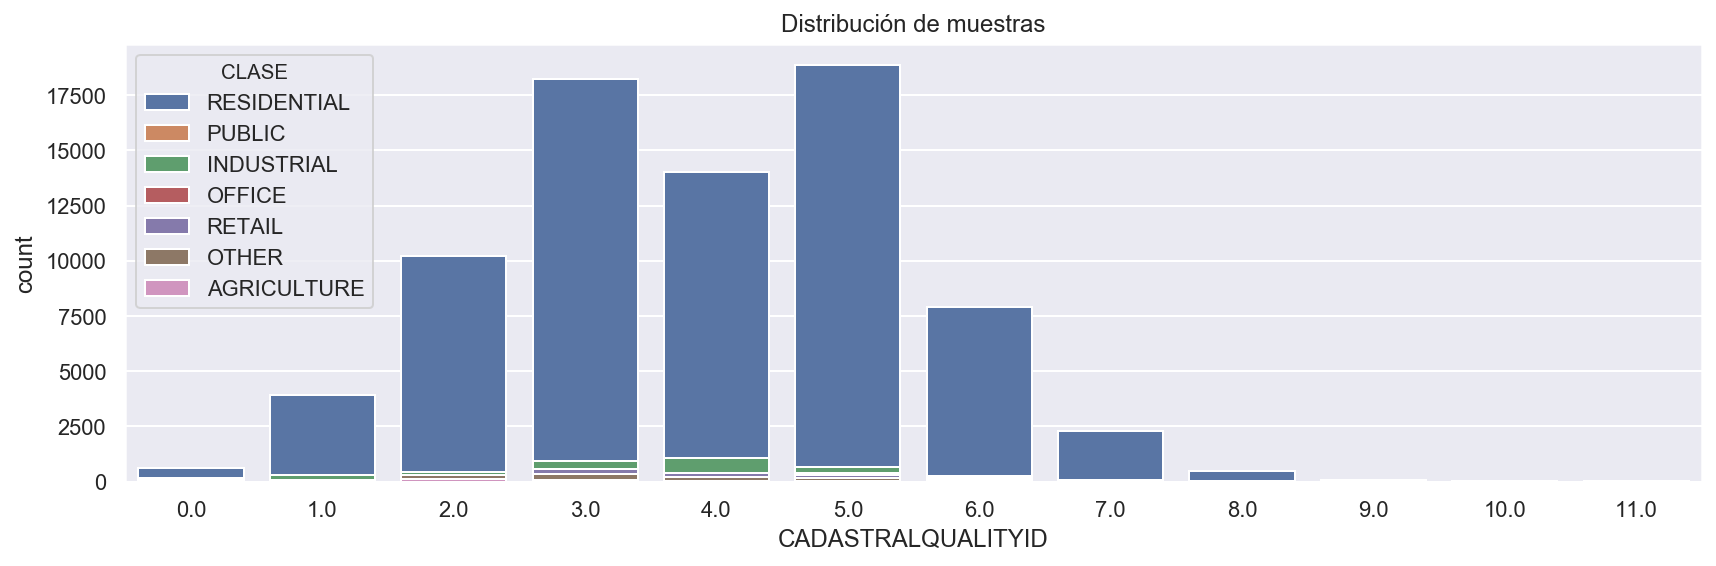

In [53]:
plt.figure(figsize=(12,4))
sns.countplot(x=df_modelar_aux['CADASTRALQUALITYID'], data=df_modelar_aux, hue="CLASE", dodge=False)
plt.title('Distribución de muestras');
plt.tight_layout()

Además del gráfico, donde observamos las diferentes clases con respecto a cada uno de los identificadores catastrales, vamos a agrupar por clase y sobre ello, vamos a obtener cuantos valores de cada identificador catatral presenta cada clase, para ver si nos arroja mayor información con respecto a esta variable.

In [54]:
cadatral_by_class = df_modelar_aux.groupby('CLASE')['CADASTRALQUALITYID'].value_counts().unstack()
cadatral_by_class

CADASTRALQUALITYID,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
CLASE,,,,,,,,,,,,
AGRICULTURE,1.0,33.0,99.0,64.0,36.0,25.0,7.0,NaN,NaN,8.0,NaN,NaN
INDUSTRIAL,164.0,317.0,432.0,925.0,1076.0,669.0,157.0,39.0,6.0,24.0,NaN,3.0
OFFICE,56.0,88.0,150.0,218.0,303.0,394.0,196.0,81.0,34.0,17.0,9.0,8.0
OTHER,17.0,65.0,282.0,333.0,228.0,150.0,44.0,8.0,3.0,2.0,NaN,NaN
PUBLIC,54.0,211.0,307.0,459.0,540.0,576.0,246.0,68.0,15.0,45.0,5.0,4.0
RESIDENTIAL,608.0,3900.0,10202.0,18238.0,13999.0,18882.0,7924.0,2301.0,483.0,76.0,20.0,14.0
RETAIL,30.0,63.0,271.0,557.0,384.0,301.0,109.0,32.0,14.0,11.0,3.0,3.0


In [55]:
cadatral_by_class.sum()

CADASTRALQUALITYID
0.0       930.0
1.0      4677.0
2.0     11743.0
3.0     20794.0
4.0     16566.0
5.0     20997.0
6.0      8683.0
7.0      2529.0
8.0       555.0
9.0       183.0
10.0       37.0
11.0       32.0
dtype: float64

Como podemos observar tras la agrupación, la calidad mayoritaria es la 5, que representaría aproximadamente la calidad media en el catastro. Por otro lado, la calidad más alta (11 o A) presenta un número muy bajo de registros en comparación con el resto y la mayor parte de los mismos están clasificados como `RESIDENTIAL`. Si nos fijamos, también podemos observar que los registros clasificados como `AGRICULTURE` son los que peor calidad catrastral presental.

Además, el mayor número de registros clasificados como `INDUSTRIAL` se situan en un rango entorno a una calidad de nivel 4, 5 y 6.

A continuación vamos a intentar obtener mayor información con respecto a otra variable que creemos que es crucial, como es el área.

In [56]:
df_modelar_aux.groupby('CADASTRALQUALITYID')['AREA'].mean()

CADASTRALQUALITYID
0.0     1383.886509
1.0      393.654502
2.0      365.287161
3.0      352.920520
4.0      466.684116
5.0      468.006710
6.0      482.991259
7.0      458.680182
8.0      541.408998
9.0     1743.504286
10.0    1347.750091
11.0    1277.242571
Name: AREA, dtype: float64

Podemos concluir que los registros que se encuentran con identificador catastral entre el 9, 10 y 11 son los que mayor área presentan junto con los de valor 0, mientras que el resto presentan un área muy similar rondando el valor medio de 400 aproximadamente.

---

<a id="section4"></a>
## <font color="#004D7F"> 4. Preprocesamiento del conjunto de datos</font>

Una vez realizado el análisis exploratorio de los datos y de las variables del _dataframe_ proporcionado, se deben de llevar a cabo las acciones de preprocesamiento necesarias.

Para ello haremos uso de la lista de funciones creada con anterioridad. En ella se han ido incluyendo las funciones necesarias y aunque en este caso unicamente contamos con una, como se ve a continuación, podemos añadir las que consideremos oportunas.

In [57]:
print("\nPasos de preprocesamiento: ")
for step, function in enumerate(list_preprocess_function):
    print("\t {:d}: {:s}".format(step, function.__name__))


Pasos de preprocesamiento: 
	 0: process_cadastral


La siguiente celda aplica cada una de las funciones de la lista al _dataframe_ que le introduzcamos como parámetro y devolverá el _dataframe_ modificado al realizar el preprocesamiento.

In [58]:
def preprocess_data(df, list_preprocess_function):
    for func in list_preprocess_function:
        func(df)
    return df

In [59]:
preprocess_data(df_modelar, list_preprocess_function)

,X,Y,Q_R_4_0_0,Q_R_4_0_1,Q_R_4_0_2,Q_R_4_0_3,Q_R_4_0_4,Q_R_4_0_5,Q_R_4_0_6,Q_R_4_0_7,...,Q_NIR_8_1_0,AREA,GEOM_R1,GEOM_R2,GEOM_R3,GEOM_R4,CONTRUCTIONYEAR,MAXBUILDINGFLOOR,CADASTRALQUALITYID,CLASE
ID,,,,,,,,,,,,,,,,,,,,,
32495F6F5B3D012D,2218599328,165740446,0.000000e+00,341.999185,508.998688,644.999683,767.999805,889.001648,1019.992651,1173.999329,...,6719.040030,280.099835,0.147746,0.026358,0.020012,0.759253,1998,3.0,6.0,RESIDENTIAL
F3DED6C32C3AF640,2274027356,165666951,2.796403e-11,519.999756,656.998657,752.000092,840.000061,936.998871,1049.999878,1209.999023,...,7173.107369,274.522959,0.450799,0.066489,0.024697,0.371450,1973,2.0,4.0,RESIDENTIAL
7B3EE36498F19B20,2212893511,165655704,0.000000e+00,364.999878,548.002014,696.005035,828.997742,954.005249,1098.000244,1262.999084,...,7545.798645,536.030810,0.511855,0.031980,0.029860,0.933712,1964,6.0,4.0,RESIDENTIAL
AAE6E75EF15C8FFE,2225521292,165661643,0.000000e+00,316.997635,503.003845,655.999390,798.997314,941.999359,1097.001221,1271.008667,...,5448.082132,581.658490,0.330438,0.022326,0.025445,1.139707,1992,5.0,4.0,RESIDENTIAL
5A4E48F0B5A2EF0B,2205830838,165864858,0.000000e+00,357.002701,513.001526,636.004059,758.998230,888.000305,1041.995117,1216.001160,...,12361.802028,41.907200,0.685767,0.238095,0.068729,0.288660,1965,1.0,2.0,RESIDENTIAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
F889ABD17D0CA833,2193630693,165441964,2.751640e-11,397.001868,580.999023,726.002234,854.014478,981.002075,1119.000879,1264.998499,...,5404.656680,101.373750,0.512216,0.072254,0.069930,0.967832,1980,4.0,3.0,RESIDENTIAL
701C0FB28D4B9B1A,2217542612,165797757,0.000000e+00,326.004053,514.001172,671.001691,819.998169,963.002045,1110.996777,1276.998474,...,5738.866020,461.627827,0.483444,0.034601,0.030266,0.874712,1988,7.0,4.0,RESIDENTIAL
A8AA1D5BE28D60D0,2174324870,165480166,0.000000e+00,230.000186,378.405115,523.001740,646.000208,773.012451,915.998193,1080.996216,...,6051.309064,127.526868,0.520279,0.075188,0.054261,0.721669,1968,8.0,4.0,RESIDENTIAL


Una vez aplicadas cada una de las funciones anteriores, es importarte eliminar o añadir a las dos listas que manejabamos de vairables categórigas y numéricas las columnas que realmente pertenecen a ese tipo. Por ello, como la variable `CADASTRALQUALITYID` se ha tratado al final como una numérica, debemos de incluirla y eliminarla de las listas correspondientes.

In [60]:
dis_df_columns.remove('CADASTRALQUALITYID')
number_df_columns.append('CADASTRALQUALITYID')

Por último, a nivel informativo, se muestra en la siguiente celda las distintas columnas que se incluyen en cada una de las listas en función del tipo de variable que representan tras realizar el preprocesamiento de correspondiente y sabiendo que se ha eliminado la variable objetivo `CLASE` de la lista de variables categóricas.

In [61]:
print('Variables categóricas: ', dis_df_columns, end='\n\n')
print('Variables numéricas: ', number_df_columns)

Variables categóricas:  []

Variables numéricas:  ['X', 'Y', 'Q_R_4_0_0', 'Q_R_4_0_1', 'Q_R_4_0_2', 'Q_R_4_0_3', 'Q_R_4_0_4', 'Q_R_4_0_5', 'Q_R_4_0_6', 'Q_R_4_0_7', 'Q_R_4_0_8', 'Q_R_4_0_9', 'Q_R_4_1_0', 'Q_G_3_0_0', 'Q_G_3_0_1', 'Q_G_3_0_2', 'Q_G_3_0_3', 'Q_G_3_0_4', 'Q_G_3_0_5', 'Q_G_3_0_6', 'Q_G_3_0_7', 'Q_G_3_0_8', 'Q_G_3_0_9', 'Q_G_3_1_0', 'Q_B_2_0_0', 'Q_B_2_0_1', 'Q_B_2_0_2', 'Q_B_2_0_3', 'Q_B_2_0_4', 'Q_B_2_0_5', 'Q_B_2_0_6', 'Q_B_2_0_7', 'Q_B_2_0_8', 'Q_B_2_0_9', 'Q_B_2_1_0', 'Q_NIR_8_0_0', 'Q_NIR_8_0_1', 'Q_NIR_8_0_2', 'Q_NIR_8_0_3', 'Q_NIR_8_0_4', 'Q_NIR_8_0_5', 'Q_NIR_8_0_6', 'Q_NIR_8_0_7', 'Q_NIR_8_0_8', 'Q_NIR_8_0_9', 'Q_NIR_8_1_0', 'AREA', 'GEOM_R1', 'GEOM_R2', 'GEOM_R3', 'GEOM_R4', 'CONTRUCTIONYEAR', 'MAXBUILDINGFLOOR', 'CADASTRALQUALITYID']


---

<a id="section41"></a>
### <font color="#004D7F">4.1 Creación de un Pipeline para la transformación </font>

Los _Pipelines_ son una herramienta extremadamente simple pero que nos permite ahorrar y gestionar flujos de trabajo en este tipo de problemas. Los _Pipelines_ están diseñados para aplicar una serie de transformaciones de datos seguidas por la aplicación de un estrimador.

Surgen por la necesidad de tratar de manera separada los datos, es decir, las variables categóricas se deben de tratar de distinta forma a las variables numéricas pero, posteriormente se deben de unir (mediante el uso del objeto ColumnTransformer)

En primer lugar, en la siguiente celda se crea un objeto de tipo _Pipeline_ que permite definir el proceso de transformación de las variables numéricas. Este objeto consiste en lo siguiente:
* Imputación de los valores perdidos mediante SimpleImputer, el cual tiene como estrategia _constant_ para completar con un valor establecido por nosotros mismos, que es el -1, que indicaría la peor calidad del catastro. 
* Normalización a media cero y desviación uno mediante el uso de StandardScaler.

In [62]:
#Transformación que se le va a aplicar a las columnas numéricas
num_transformer = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value=-1)),
                             ('scaler', StandardScaler())])

De igual formar que se ha realizado para las variables numéricas, también se debe de realizar para las variables categóricas. En este caso, el objeto _Pipeline_ creado consta de lo siguiente:
* Imputación de los valores perdidos mediante _SimpleImputer_ reemplazando los valores perdidos por una etiqueta, de forma similar al caso anterior.
* Transformación de las variables categóricas a etiquetas binarias mediante un objeto _OneHotEncoder_

<div class="alert alert-block alert-warning">
    
<i class="fa fa-exclamation-circle" aria-hidden="true"></i> Importante. Esto es solo una propuesta de trabajo y de desarrollo. En nuestro caso no contamos con variables categóricas a tratar, por lo que no es necesario la realización de este _Pipeline_ pero se adjunta a nivel informativo o por si en algun caso se añade alguna variable de este tipo.
</div>

In [63]:
#Transformación que se le aplicaría a las columnas categóricas, en el caso de que existan
cat_transformer = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                           ('onehot', OneHotEncoder(handle_unknown='ignore'))])

Po último, una vez se tienen las dos secuencias de transformaciones anteriores, se deben de unir y aplicar a las características correspondientes. Para ello se hace uso de un objeto incluido recientemente en la librería de _scikit-learn_ llamado `ColumnTransformer`, que permite tratar por separado estas columnas.

En nuestro caso, este objeto se ha creado unicamente con el _Pipeline_ de las variables numéricas porque no tenemos variables categóricas a tratar.

In [64]:
#Transformador que se aplica a cada una de las columnas en función a lo declarado previamente
df_modelar_trans = ColumnTransformer(transformers=[('num', num_transformer, number_df_columns)])

---

<a id="section5"></a>
## <font color="#004D7F"> 5. Construcción de modelos </font>

El principal problema que tenemos a la hora de construir los modelos es el del gran desbalanceo de las clases que hemos visto en el apartado de [Análisis exploratorio de los datos](#section3), donde tenemos la clase `RESIDENTIAL` como clase predominante con respecto al resto.

Para solventar este problema, vamos a utilizar la estrategia de **apilamiento de modelos**, es decir, utilizar un primer modelo que nos discrimine entre las clases `RESIDENTIAL` y `NO RESIDENTIAL`, la cual estará constituida por todos los registros cuya clase sea distinta a `RESIDENTIAL`.

Lo que conseguimos con esto es hacer un filtro de los datos y una vez obtengamos los registros cuya predicción sea `NO RESIDENTIAL` entonces los pasaremos a un segundo modelo (multietiqueta), el cual estará entrenado con todas las clases más balanceadas, manteniendo las distribuciones originales del conjunto de datos.

Dado que el primer modelo va seguir estando desbalanceado, puesto que disponemos de 90173 registros cuya clase es `RESIDENTIAL` y 23230 cuya clase es distinta a `RESIDENTIAL`, vamos a utilizar una técnica de **Oversampling**.
Con esta técnica vamos a generar registros sintéticos similares a los que tenemos en el conjunto de datos inicial mediante el algoritmo `SMOTE` (*Synthetic Minority Over-sampling Technique*) cuyo funcionamiento queda reflejado en el <a href="https://arxiv.org/pdf/1106.1813.pdf">siguiente artículo</a>.

Con todo ello vamos a generar un modelo binario lo más balanceado posible, igualando los registros de la clase `RESIDENTIAL` y los `NO RESIDENTIAL`, como se muestra a continuación:

<div class="alert alert-block alert-danger">
    
<i class="fa fa-exclamation-triangle" aria-hidden="true"></i>
Los ejemplos aquí mostrados son representativos, pero los datos no son los reales debido a que no se ha realizado todavía el proceso. Lo importante es que se comprenda la idea que se quiere transmitir y el funcionamiento del algoritmo SMOTE.

Esto es así debido a que el algoritmo SMOTE se aplicará en un pipeline al conjunto de train obtenido tras hacer una subdivisión aleatoria de los datos, por lo tanto, no sabemos a ciencia cierta cuántos valores habrá de la clase mayoritaria.
</div>

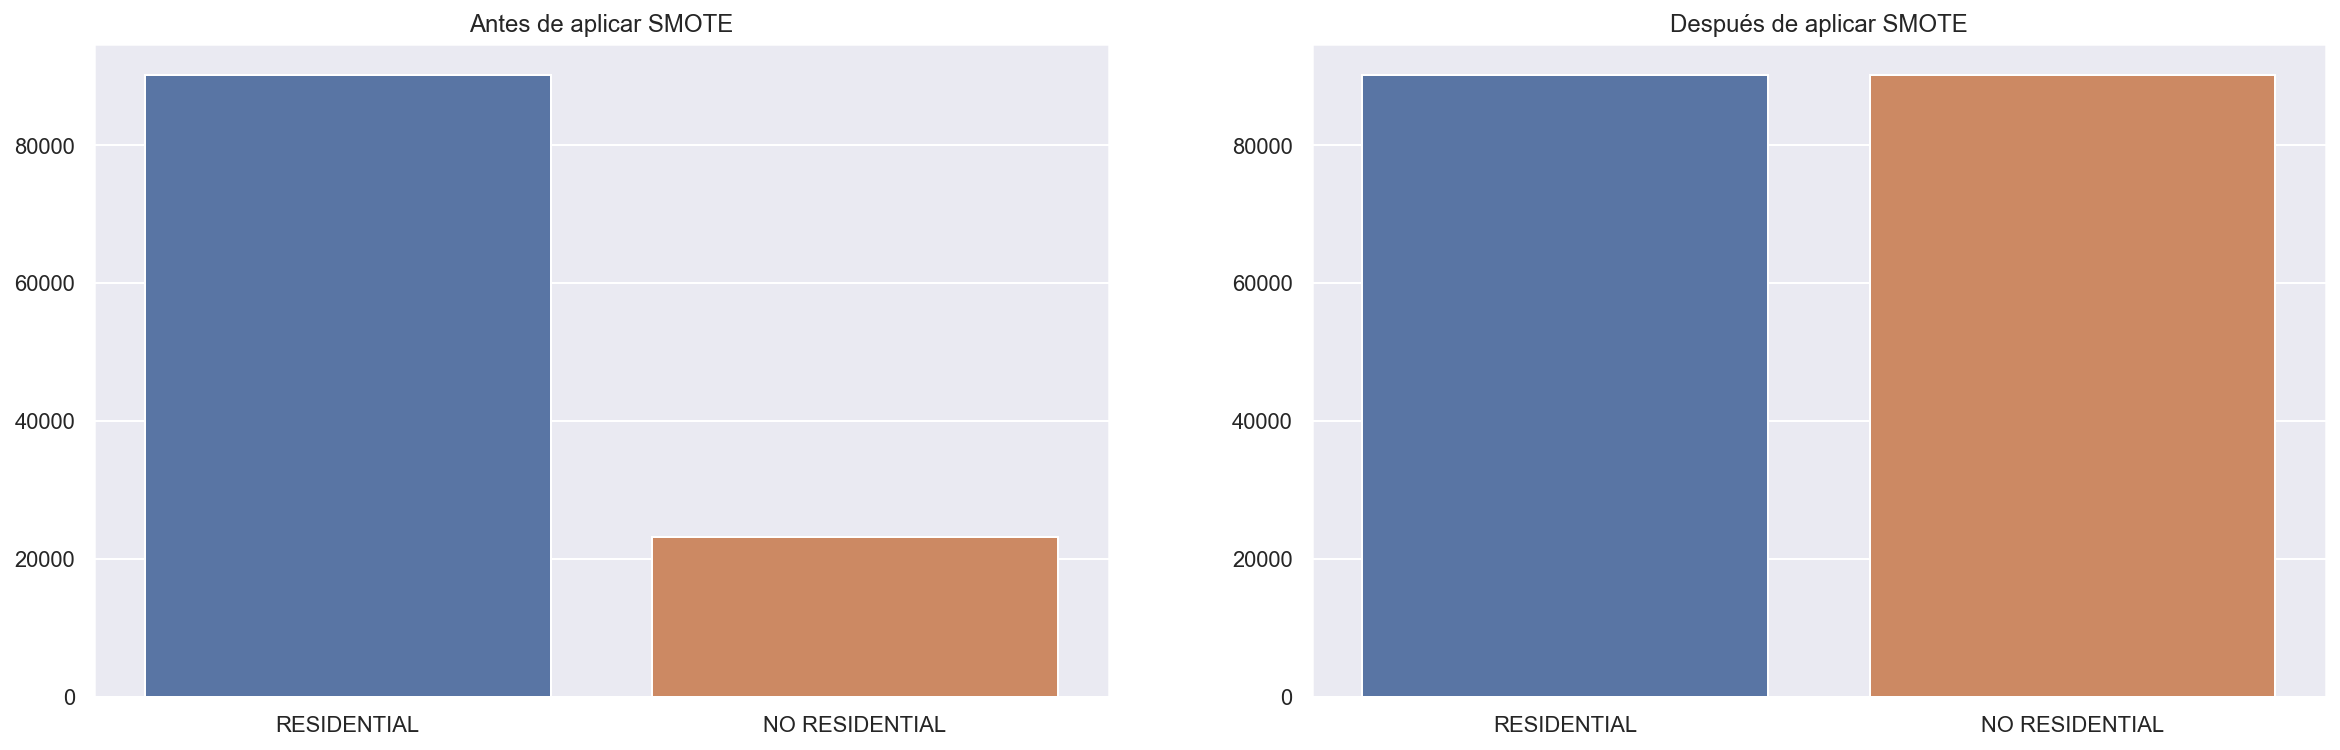

In [65]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,6))
sns.barplot(x=['RESIDENTIAL', 'NO RESIDENTIAL'], y=[90173, 23230], ax=ax1)
sns.barplot(x=['RESIDENTIAL', 'NO RESIDENTIAL'], y=[90173, 90173], ax=ax2)
ax1.set_title('Antes de aplicar SMOTE')
ax2.set_title('Después de aplicar SMOTE')
plt.show()

Sobre el nuevo conjunto de datos balanceado, entrenaremos una serie de modelos realizando una búsqueda exhaustiva de los mejores hiperparametros para conseguir obtener el mejor modelo con respecto a unas métricas establecidas.

Una vez obtengamos el modelo binario, diferenciando entre `RESIDENTIAL` y `NO RESIDENTIAL`, se debe de generar un segundo modelo, pero esta vez multietiqueta.
Este segundo modelo contemplará todas las clases presentes en la variable objetivo del conjunto de datos inicial, pero, con la condición de que ahora la clase mayoritaria no será `RESIDENTIAL` ya que ha sido previamente clasificada por el primer modelo (binario).

A consecuencia de ello, es necesario que el modelo multietiqueta se entrene con una distribución acorde al nuevo escenario de datos, el cual se puede observar a continuación:

<div class="alert alert-block alert-danger">
    
<i class="fa fa-exclamation-triangle" aria-hidden="true"></i>
Recordamos que estos datos son aproximaciones y no son reales, son simplemente para ayudarnos en la explicación de la estrategia utilizada.
</div>

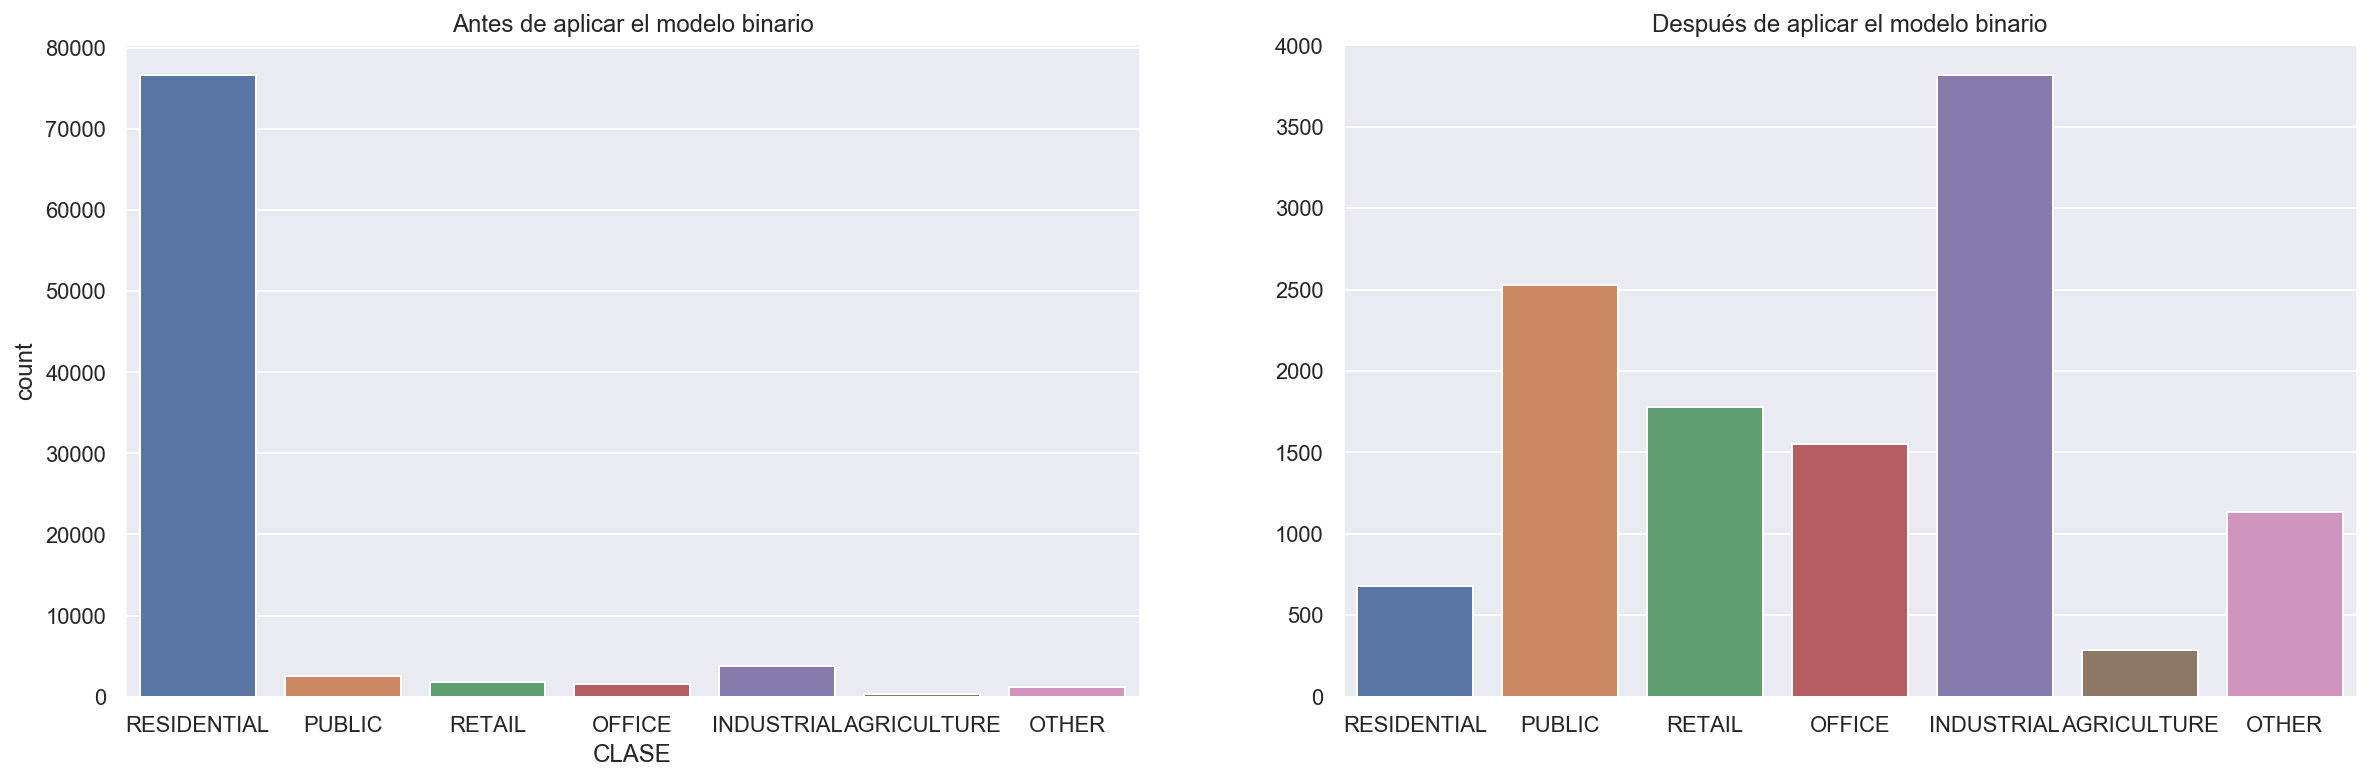

In [66]:
datos_filtrados = df_modelar[df_modelar['CLASE']!='RESIDENTIAL']['CLASE'].value_counts() \
        .append(pd.Series(index=['RESIDENTIAL'], data=[678]))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,6))
sns.countplot(df_modelar['CLASE'], order=list_class_order, ax=ax1)
sns.barplot(x=datos_filtrados.index, y=datos_filtrados.values, order=list_class_order, ax=ax2)
ax1.set_title('Antes de aplicar el modelo binario')
ax2.set_title('Después de aplicar el modelo binario')
plt.show()

Como se puede observar en las gráficas, tras la aplicación del modelo binario se ha conseguido balancear los datos manteniendo las proporciones originales del resto de clases que no son clasificadas como `RESIDENTIAL`. Puede resultar extraño el hecho de que aún haya registros de esta clase una vez aplicado el modelo binario, pero, esto se debe a que el modelo puede presentar fallos a la hora de clasificar estos datos y por lo tanto, clasifique casos de la clase `RESIDENTIAL` como `NO RESIDENTIAL`.

Con la estrategia que se ha llevado a cabo, la clase `RESIDENTIAL` también podrá ser clasificada y tener una _segunda oportunidad_ en el modelo multietiqueta. Así pues, se pretende corregir en la medida de lo posible los fallos del modelo binario en el modelo multietiqueta.

La estrategia a aplicar en este momento es muy similar a la del modelo binario, es decir, utilizar el algoritmo `SMOTE` sobre el conjunto de datos para conseguir balancear las clases y una vez se realicé, entrenar el modelo multietiqueta. 

Tras ello, el conjunto de entrenamiento en nuestro segundo modelo será simiar al mostrado a continuación:

<div class="alert alert-block alert-danger">
    
<i class="fa fa-exclamation-triangle" aria-hidden="true"></i>
Recordamos que estos datos son aproximaciones y no son reales, son simplemente para ayudarnos en la explicación de la estrategia utilizada.
</div>

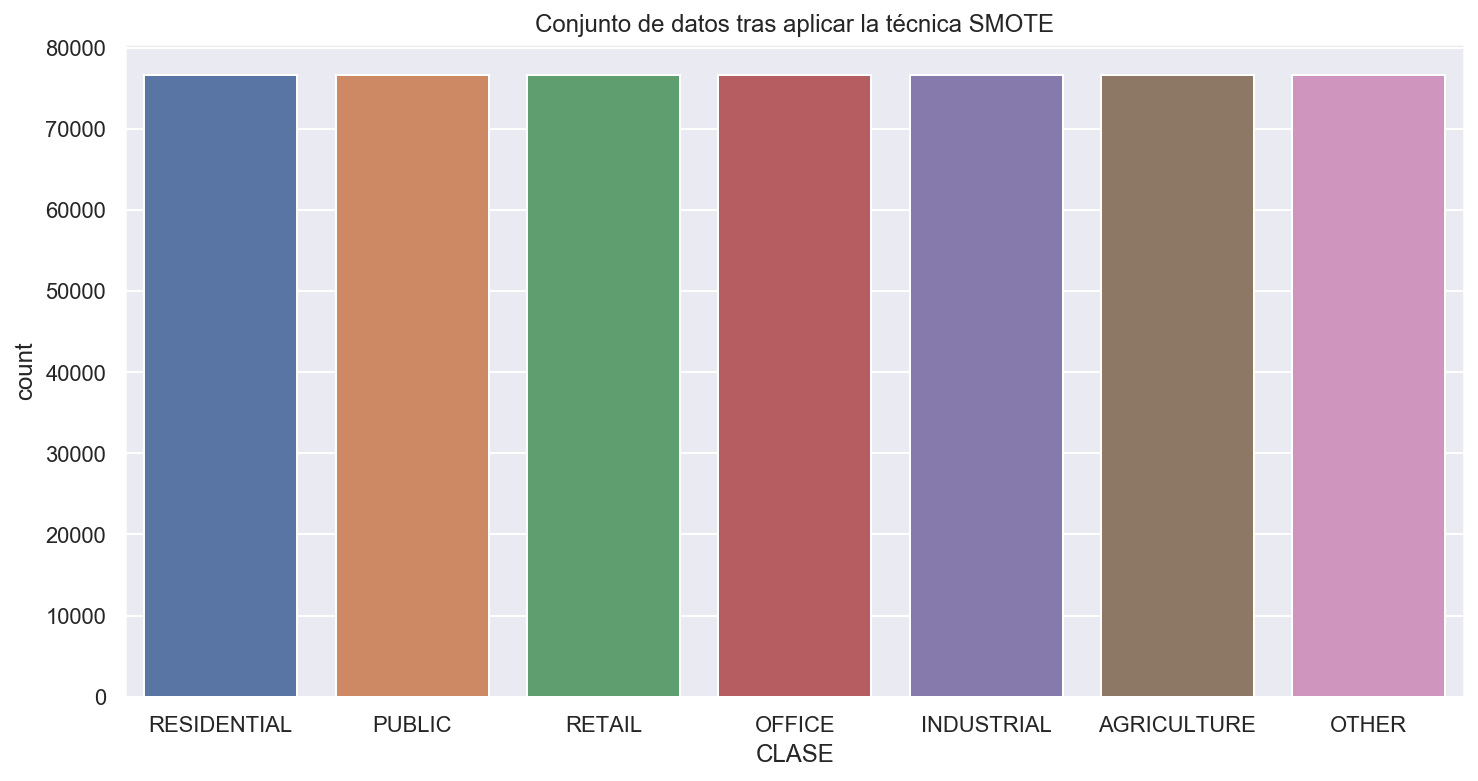

In [67]:
datos_filtrados = df_modelar[df_modelar['CLASE']=='RESIDENTIAL']['CLASE'].value_counts()
for c in df_modelar['CLASE'].unique():
    if c != 'RESIDENTIAL':
        datos_filtrados = datos_filtrados.append(pd.Series(index=[c], data=[datos_filtrados[0]]))
plt.figure(figsize=(12,6))
sns.barplot(x=datos_filtrados.index, y=datos_filtrados.values, order=list_class_order)
plt.title('Conjunto de datos tras aplicar la técnica SMOTE')
plt.xlabel('CLASE')
plt.ylabel('count')
plt.show()

En definitiva, la estrategia que se va a realizar se presenta en el siguiente diagrama:

<img src="data/diagrama_modelos.png">

---

<a id="section51"></a>
### <font color="#004D7F">5.1 Construcción de modelo binario </font>


Lo primero que debemos hacer es generar una nueva variable en función a la variable `CLASE` que nos permita identificar si el registro hace referencia a la clase `RESIDENTIAL` o `NO RESIDENTIAL`. Para ello, vamos a hacer uso de la siguiente función:

In [68]:
def assing_subclass(df):
    df['SUBCLASE'] = (df['CLASE'] == 'RESIDENTIAL').astype(int)
assing_subclass(df_modelar)

Una vez generada la nueva variable, es hora de utilizar el algoritmo `SMOTE`. El cual nos va a permitir realizar un aumento de registros de manera sintética con respecto aquellos de la clase minoritaria, es decir, la no residencial.

In [ ]:
#Separamos en conjunto de datos, de la variable a predecir, que en este caso es la nueva que hemos generado en el paso previo
X = df_modelar.drop(columns=df_modelar.columns[-2:]).copy() #Importante, debemos eliminar también la variable clase para no afectar en el entrenamiento
y = df_modelar['SUBCLASE'].copy() #La clase a predecir va a ser la que hemos generado y la que nos va a permitir discretizar

#Realizamos un SMOTE para la clase minoritaria para así balancear el conjunto de datos
sm = SMOTE(random_state=10, sampling_strategy='not majority')

Seguidamente, el nuevo conjunto de datos generado debemos dividirlo en un conjunto de train y de test para poder entrenar nuestros modelos.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=10)

Con respecto a que modelos de clasificación debemos entrenar, hemos optado por los siguientes algoritmos de clasificación. A pesar de que hay una gran variedad, estos son los que nosotros conocemos con mayor precisión y nos sentimos más cómodos de utilizar:
- <a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html">LogisticRegression</a>
- <a href="https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html">DecisionTreeClassifier</a>
- <a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html">RandomForestClassifier</a>
- <a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html">SGDClassifier</a>
- <a href="https://xgboost.readthedocs.io/en/latest/python/python_api.html">XGBOOST</a>

Para el entrenamiento de cada uno de los diferentes algoritmos de clasificación se ha utilizado una de las funciones incluidas en el paquete de *scikit-learn*, llamada `GridSearchCV`. Mediante esta función nos es posible evaluar y seleccionar los mejores parámetros para el algoritmo de clasificación en cuestión.

Para ello hace uso de la _validación cruzada_ con el fin de evitar la aparación de sobreajuste y dando como resultado modelos más estables y con mejores resultados. La _validación cruzada_ consiste en dividir el conjunto de entramiento en grupos de igual tamaño y entrenar el modelo una vez por cada uno de los diferentes grupos creados. Así pues, se utilizan todos los grupos excepto el de la iteración para entrenar el algoritmo y el restante para la validación del mismo.

En la siguiente imagen que se adjunta y que ha sido extraida de <a href="https://www.analyticslane.com/2018/07/02/gridsearchcv/">Analytic Lane</a> se puede ver un ejemplo muy sencillo de este método:

<img src="data/validacion_cruzada.jpeg">

Además, los parámetros que hemos incluido en cada uno de los _GridSearchCV_ son los siguientes:

* **estimator**: algoritmo/modelo que se desea evaluar. En nuestro caso este parámetro lo completamos introduciendo el _Pipeline_ creado.
* **parameters**: diccionario en el cual se indican los distintos parámetros que se han de evaluar.
* **cv**: número total de conjuntos en los cuales se va a dividir el conjunto de datos para la _validación cruzada_.
* **n_jobs**: para que el procesamiento utilice todos los núcleos disponibles en el ordenador o máquina que se ejecute.
* **scoring**: métrica utilizada para evaluar el modelo.
* **refit**: este parámetro hace que, una vez concluida y obtenida la mejor configuración de los parámetros, se entrene el modelo con todos los datos.
* **verbose**: este parámetro nos permite obtener información sobre el estado de la ejecución del gridsearch.

<div class="alert alert-block alert-danger">
    
<i class="fa fa-exclamation-triangle" aria-hidden="true"></i>
Este proceso conlleva un importante uso de los recursos del ordenador y de tiempo de entrenamiento de cada modelo con sus hiperparametros, por lo que se recomienda no ejecutar salvo que sea estrictamente necesario.
</div>

En la siguiente celda se ha desarrollado una función que nos permite ejecutar un conjunto de modelos, los cuales debemos de declarar previamente.

Para ello existe una variable en la cual se añaden los modelos y los hiperparámetros necesarios para su entrenamiento. Posteriormente, este diccionario de modelos se usa en la función implementada, la cual mediante un _GridSearchCV_ obtendrá el mejor de cada uno de ellos y los almacenará en un diccionario, con la finalidad de poder acceder a él en cualquier momento.

Hemos decidido utilizar como función de scoring el _f1-score_ debido a que al tratarse en este caso de un problema binario, queremos obtener aquellos modelos que mejor _f1-score_ obtengan, en vez de centrarnos en el _accuracy_. En definitiva, creemos que el _f1-score_ se trata de una mejor métrica de cara a entrenar nuestros modelos, conociendo el objetivo que queremos alcanzar.

In [ ]:
seed = 10

models = [
    'SGD',
    'Logistic regression',
    'Decision tree',
    'Random forest',
    'Xgboost'
]

params = { 
        'SGD': 
            {'clf': SGDClassifier(random_state=seed),
            'params': [{'clas__max_iter': [50, 100, 1000], 'clas__tol': [1e-3, 1e-4]}]},
        'Logistic regression': 
            {'clf': LogisticRegression(random_state=seed),
            'params': [{'clas__tol': [0.001,0.0001,0.00001], 'clas__C': np.linspace(0.0001,1.0,5)}]},
        'Decision tree': 
            {'clf': DecisionTreeClassifier(random_state=seed),
            'params': [{'clas__max_depth': [3, 5, 7, 10]}]},
        'Random forest': 
            {'clf': RandomForestClassifier(random_state=seed),
            'params': [{'clas__n_estimators': [100, 200], 'clas__max_depth': [5, 10, 20]}]},
        'Xgboost':
            {'clf': xgb.XGBClassifier(random_state=seed),
            'params': [{'clas__n_estimators': [100, 200], 'clas__max_depth': [5, 10, 20]}]}
}

results = {}

def train_models(models):
    for m in models:
        start_time = time.time()
        print(f"----Vamos a entrenar el modelo: {m}----")
        model = params[m]['clf']
        parameters = params[m]['params']
        
        pipe = Pipeline(steps=[('prep', df_modelar_trans), ('smt', sm), ('clas', model)])
        
        GS = GridSearchCV(pipe, parameters, cv=5, n_jobs=-1, scoring='f1', refit=True, verbose=1)
        GS.fit(X_train, y_train)
        
        print(f"Mejor score para el modelo {m}: ", GS.best_score_)
        print("Mejora configuración de parámetros: ", GS.best_params_)
        end_time = (time.time() - start_time)
        pipe = GS.best_estimator_
        print('----------------------------------------\n')
        results[m] = {'time': end_time, 'score': GS.best_score_, 'params': GS.best_params_, 'estimator': pipe}

Se realiza la llamada a la función que nos permite obtener cada uno de los modelos con sus mejores parámetros.

In [ ]:
train_models(models)

#### <font color="#004D7F">Comparativa diferentes algoritmos de clasificación </font>

En este apartado se explica con detenimiento los resultados obtenidos en cada uno de los diferentes algoritmos de clasificación entrenados para este primer modelo binario.

In [ ]:
times = []
accuracies = []
for m in models:
    time = np.round(results[m]["time"]/60, 3)
    f1 = np.round(results[m]["score"], 3)
    print(f'Para el modelo \033[1m{m}\033[0m el tiempo es: \033[1m{time}\033[0m minutos y el score obtenido es: \033[1m{f1}\033[0m')
    times.append(time)
    accuracies.append(f1)

<div class="alert alert-block alert-warning">
    
<i class="fa fa-exclamation-circle" aria-hidden="true"></i> Importante. El tiempo que se muestra por cada uno de los modelos entrenados hace referencia al tiempo dedicado a la búsqueda exhaustiva de los hiperparámetros junto con el entrenamiento final del modelo con mejor score obtenido (propiedad refit del gridSearch).
</div>

Como era de esperar, el algoritmo de clasificación que más tiempo ha necesitado para su correcto entrenamiento mediante un _GridSearchCV_ ha sido el **Xgboost** empleando casi 12 minutos de tiempo debido a su complejidad y operaciones internas (las cuales se explican con más detalles en la <a hr="https://xgboost.readthedocs.io/en/latest/">página oficial</a>). 

El **Random Forest** al ser también un modelo complejo, requiere algo más de tiempo en comparación con el resto de algoritmos.

Estos dos algoritmos emplean tanto tiempo porque sus hiperparámetros abarcan un amplio número de configuraciones y hemos introducido un número de estimadores y de profundidad (la cual hemos limitado para que no sobreajuste nuestro modelo a los datos de entrenamiento).

El **SGD** , **Logistic regression** y **Decision tree** son algoritmos de clasificación _sencillos_ que no generan un conjunto de modelos como es el caso del Random Forest y el Xgboost, por lo que no presentan un alto tiempo de entrenamiento.

In [ ]:
plt.figure(figsize=(16,6))
plt.title("Tiempos obtenidos en el entrenamiento de los modelos")
plt.barh(range(len(times)), times, align='center')
plt.yticks(range(len(models)), models, fontsize=9)
plt.xlabel('Tiempo (m)')
plt.show()

plt.figure(figsize=(16,6))
plt.title("Accuracy obtenidos en el entrenamiento de los modelos")
plt.barh(range(len(accuracies)), accuracies, align='center')
plt.yticks(range(len(models)), models, fontsize=9)
plt.xticks(np.linspace(0,1,5))
plt.xlabel('F1-score')
plt.show()

En la primera gráfica que se muestra en la parte superior de esta celda se puede observar el tiempo empleado por cada uno de los distintos algoritmos de clasificación empleados para este problema, los cuales se han comentado con anterioridad.

En nuestro caso, como el objetivo para el primer modelo es intentar maximizar el _f1-score_ lo máximo posible solamente nos fijaremos en dos de los algorimos entrenados: el **Xgboost** y el **Random Forest** los cuales compararemos más en profunidad a continuación.

En la segunda gráfica se ha representado de forma gráfica el _f1-scpre_ obtenido con cada uno de los diferentes algoritmos y como era casi de esperar, el **Xgboost** es el que mayor _f1-score_ presenta, seguido del **Random Forest**. El resto de algoritmos no obtiene un mal resultado, pero debemos de tener en cuenta que a priori nos puede parecer un _f1-score_ lo suficientemente alto como para barajar la posibilidad de usar estos algoritmos, pero nuestro conjunto de datos está altamente desbalanceado y por ello se obtienen resultados tan elevados.

Es por ello por lo que se deben de consultar otro tipo de métricas adicionales, que se explicarán a continuación.

Es la siguiente tabla, se muestra a modo de resumen, toda la información obtenida de cada uno de los algoritmos. Se divide en:
* **Modelo:** algoritmo de clasificación utilizado.
* **Time(m):** tiempo (en minutos) empleado para su entrenamiento.
* **F1 score:** resultado obtenido en la métrica empleada en cada uno de ellos.
* **Params** parámetros utilizados en el _GridSearchCV_ para el entrenamiento de los algoritmos de clasificación.

<table class="table table-hover">
    <thead>
        <tr> <th>Modelo</th> <th>Time (m)</th> <th>F1 score</th><th>Params</th></tr> 
    </thead>
    <tbody>
        <tr> <td>SGD</td> <td>0.396</td> <td>0.911</td> <td>max_iter: 100, tol: 0.0001</td> </tr>
        <tr> <td>Logistic regression</td> <td>0.901</td> <td>0.75</td> <td>C: 0.250075, tol: 0.001</td> </tr>
        <tr> <td>Decision tree</td> <td>0.278</td> <td>0.929</td> <td>max_depth: 10</td> </tr>
        <tr> <td>Random forest</td> <td>3.15</td> <td>0.951</td> <td>max_depth: 20, n_estimators: 200</td> </tr>
        <tr> <td>Xgboost</td> <td>12.023</td> <td>0.96</td> <td>max_depth: 10, n_estimators: 200</td> </tr>
    </tbody>
</table>

#### <font color="#004D7F">Obtención de las predicciones para los modelos de interés</font>

Una vez se ha entrenado correctamente cada uno de los diferentes modelos, y partiendo de la base de que unicamente vamos a realizar la comprobación con el **Random Forest** y el **Xgboost** se deben de calcular las predicciones para cada uno de ellos, estudiarlas y seleccionar el modelo que mejor se ajuste a nuestras necesidades.

In [ ]:
def analize_model(m, X_test, y_test, accuracy=True, prc=False, ranking=False):
    estimator = results[m]['estimator']
    y_pred = estimator.predict(X_test)
    if accuracy:
        show_results(y_test, y_pred)
    if prc:
        #plot_precision_recall_curve(estimator, X_test, y_test);
        plot_roc_curve(y_test, y_pred)
    if ranking:
        if (m in ['Decision tree', 'Random forest', 'Xgboost']):
            # Extrae las importancias
            importances = estimator['clas'].feature_importances_
            # Extrae los índices ordenados de menor a mayor
            ranking = np.argsort(importances)

            #Ahora que hemos obtenido las importancias de las variables y su ranking, vamos a dibujarlo
            plt.figure(figsize=(28,20))
            plt.title(f"Ranking de importancias de las variables con {m}")
            plt.barh(range(df_modelar.shape[1]-2), importances[ranking],color=sns.diverging_palette(220, 20, n=55),align='center')
            plt.yticks(range(df_modelar.shape[1]-2), X.columns[ranking], fontsize=9)
            plt.show()
    print('\n')

Primero vamos a analizar el modelo obtenido del `Random forest` vs `Xgboost`. Analizaremos las matrices de confusión obtenidos por cada uno de ellos, las gráficas de precision recall, y finalmente, las variables más importantes para cada uno de los modelos a la hora de clasificar.

Para comenzar, analizaremos una serie de métricas que son las siguientes:
* **Accuracy**: el accuracy se define como el porcentaje de casos acertados por el clasificador.
* **Precision**: la precisión se define como el porcentaje de clasificaciones correctas realizadas por el modelo entrenado, es decir, de todo lo que el moodelo clasifica positivo, cual es el ratio de acierto.
* **Recall**: el recall se define como el porcentaje de casos positivos detectados por el modelo, es decir, de todos los positivos reales (sean detectados o no), cual es el porcentaje de positivos acertados.
* **F1-score**: el f1-score se define como la media entre la precision y el recall. Simplemente es una métrica que permite la combinación de las anteriores, asumiento que ambas tienen la misma importancia.

Para el caso del **Random Forest** podemos observar que el _accuracy_ presenta muy buenos resultados teniendo en cuenta que se ha hecho un _oversample_ de los datos. Además, el resto de métricas presentan también muy buenos resultados aunque se aprecia una pequeña disminución en la _precision_ y por lo tanto en el _recall_ para el caso 0 (no residencial).

In [ ]:
analize_model('Random forest', X_test, y_test, True, False, False)

En el caso del **Xgboost** nos encontramos también con un _accuracy_ bastante alto y también con unos buenos resultados en el resto de métricas. A diferencia del **Random Forest** en este modelo se observa un mejor resultado en el caso de la métrica _precision_ y por lo tanto también del _f1-score_. Es principalmente este motivo el que nos ha hecho decantarnos por este modelo.

In [ ]:
analize_model('Xgboost', X_test, y_test, True, False, False)

A continuación vamos a comparar el _Área bajo la curva_ de los dos modelos, para comprender realmente como de bueno es con respecto al resto. Esta curva representa la tasa de verdaderos positivos frente a la tasa de falsos positivos y el AUC se encarga de medir el área bidimensional por debajo de la curva. Esta explicación se puede representar de forma gráfica en la siguiente imagen, obtenida de <a href="https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc?hl=es-419">aquí</a>.


<img src="data/AUCPredictionsRanked.svg">

El valor del AUC oscila entra 0 y 1. Por ejemplo, si tenemos un modelo con un AUC igual a 1, implica que el 100% de sus predicciones son correctas y por el contrario, si el AUC es de 0, significa que el 100% de sus predicciones son erróneas.

En el caso del **Random Forest** se presenta un AUC de 0.83, es decir, el 83% de sus predicciones son correctas. Este valor es realmente bueno, pero como hemos visto anteriormente, buscamos un equilibrio entre todas las métricas posibles.

In [ ]:
analize_model('Random forest', X_test, y_test, False, True, False)

Para el caso del **Xgboost** tenemos un AUC de 0.81, un valor también bastante bueno. Por lo tanto, ambos modelos presentan un AUC similar, ya que no existe casi diferencia entre ellos, pero son las métricas comendas anteriormente las que nos han hecho decantarnos por el **Xgboost**.

In [ ]:
analize_model('Xgboost', X_test, y_test, False, True, False)

Por último, se realiza el estudio del ranking de la importancia que presenta cada una de las diferentes variables del conjunto de datos para el modelo entrenado.

En el caso del **Random Forest** podemos observar que de todas las variables, las que mayor importancia tienen para el entrenamiento del modelo son las geométricas, las de posición y las clasificadas anteriormente como _otras_ que son `MAXBUILDINGFLOOR` y `CADASTRALQUALITYID`. Por lo cual, las variables relacionadas con los colores son las que menor importancia presencian.

In [ ]:
analize_model('Random forest', X_test, y_test, False, False, True)

A diferencia del modelo anterior, en el **Xgboost** las variables con mayor importancia son totalmente distintas, como se puede observar en la gráfica.

Anteriormente, las variables geométricas y de posición eran las que mayor importancia tenían, y aquí sin embargo se situan en las últimas posiciones de la gráfica. Por el contrario, las variables de los colores toman una mayor importancia en este modelo, mientras que variables como `MAXBUILDINGFLOOR` y `CADASTRALQUALITYID` siguen aportando bastante información a los modelos entrenados.

In [ ]:
analize_model('Xgboost', X_test, y_test, False, False, True)

Gracias a estas dos gráficas podemos observar que todas las variables son importantes y en mayor parte el resultado obtenido depende más bien del algoritmo de clasificación elegido. Para unos son importantes unas variables y para otro son otras totalmente distintas.

En esta importancia también entra en juego el tipo de variable y el tipo de algoritmo de clasificación, pero es curioso de ver como dos algoritmos no muy dispares presentan una importancia de sus variables totalmente distinta.

---

<a id="section52"></a>
### <font color="#004D7F">5.2 Construcción de modelo multietiqueta </font>

Dado que los mejores resultados en cuanto a las métricas estudiadas se han obtenido en los modelos de **Random Forest** y de **Xgboost**, aunque definitivamente hemos hecho uso únicamente de este último, para el modelo multietiqueta utilizaremos el **Random Forest** en su lugar.

Haremos uso de la misma estrategia empleada en el modelo binario, es decir, realizaremos un `SMOTE` con el propósito de balancear todas y cada una de las clases existentes en nuestro nuevo conjunto de datos y poder así entrenar el modelo multietiqueta.

En este caso, además, se puede observar que haremos uso de la variable `CLASE` en vez de la variable `SUBCLASE` generada para el modelo binario, ya que ahora queremos obtener un modelo para las 7 clasificaciones distintas que toma la variable objetivo del problema.

In [ ]:
X = df_modelar.drop(columns=df_modelar.columns[-2:]).copy()
y = df_modelar['CLASE'].copy() #En este caso utilizamos la clase a predecir en vez de la subclase generada para el primer modelo

sm = SMOTE(random_state=10, sampling_strategy='not majority')

Se realiza de nuevo la correcta separación del conjunto de datos para obtener un conjunto de _train_ y otro conjunto de _test_ y se realiza una estratificación con el fin de preservar las distribuciones de las clases en los nuevos subconjuntos.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=10)

Como se ha comentado, para este modelo multietiqueta se va a entrenar un algoritmo de clasificación denominado **Random Forest** con el cual se han obtenido buenos resultados en el caso del modelo binario. Para su entrenamiento también contamos con un _GridSearchCV_ que nos permitirá obtener los mejores hiperparametros posibles.

Es importante remarcar que hemos establecido una máxima profundidad, ya que en el caso contrario se podría producir un sobreajuste en el modelo.

In [ ]:
model = RandomForestClassifier(random_state=10)

parameters = {}
parameters['clas__max_depth'] = [5, 10, 20] #Quitamos None para que no sobreajuste al conjunto de train y que no pueda hacer la profundidad que el modelo desee. 
                                            # Lo forzamos a ponerle profundidad, como máximo 20, aunque se podría establecer mayor profundidad pero no queremos que sobreajute a los datos del train.
parameters['clas__n_estimators'] = [100, 200]
parameters['clas__class_weight'] = ['balanced']

pipe = Pipeline(steps=[('prep', df_modelar_trans), ('smt', sm), ('clas', model)])
GS = GridSearchCV(pipe, parameters, cv=5, n_jobs=-1, scoring='accuracy', refit=True, verbose=1)
GS.fit(X_train, y_train)
print(f"Mejor score: ", GS.best_score_)
print("Mejore configuración de parámetros: ", GS.best_params_)

pipe = GS.best_estimator_

Una vez conseguido el mejor modelo multietiqueta y entrenado con el conjunto de datos correspondiente, se estudian a continuación los resultados obtenidos:

In [ ]:
y_pred = pipe.predict(X_test)
show_results_multilabel(y_test, y_pred)

# Extraemos las importancias de las variables
importances = pipe['clas'].feature_importances_
# Extrae los índices ordenados de menor a mayor
ranking = np.argsort(importances)

#Ahora que hemos obtenido las importancias de las variables y su ranking, vamos a dibujarlo
plt.figure(figsize=(28,20))
plt.title(f"Ranking de importancias de las variables con Random Forest")
plt.barh(range(df_modelar.shape[1]-2), importances[ranking],color=sns.diverging_palette(220, 20, n=55),align='center')
plt.yticks(range(df_modelar.shape[1]-2), X.columns[ranking], fontsize=9)
plt.show()

El modelo obtenido presenta un buen accuracy, pero no debemos fijarnos en él debido a que esto se ve influenciado por la clase mayoritaria, es decir, `RESIDENTIAL`, ya que el conjunto de test sigue estando desbalanceada en ese aspecto. Como muestra de ello, los f1-score obtenidos por el resto de clases no es tan alto como el de la clase residencial, salvo alguna excepción como `AGRICULTURE` e `INDUSTRIAL` que superan el 0.50.

El resto de clases si que se ven afectadas debido a que el algoritmo no termina de discriminar, y por lo tanto, clasificar algunas de estas clases minoritarias aún habiendo utilizado la técnica de **SMOTE**.

La matriz de confusión tampoco nos aporta demasiada información debido a que la clase `RESIDENTIAL` presenta 23000 registros aproximadamente, mientras que la suma del resto de clases sólo alcanzan 3330. Por lo tanto, puede darnos la impresión de que el algoritmo no clasifica demasiado bien, aunque realmente si que lo hace. Sería necesario tener un conjunto de test más equilibrado con respecto a las clases para ver su correcto funcionamiento.

---

<a id="section6"></a>
## <font color="#004D7F">6. Validación de nuevos datos </font>

Una vez realizado todo lo anterior, ya tenemos nuestros dos modelos, tanto el binario como el multietiqueta y con sus resultados estudiados y analizados. Ahora, en este apartado se lleva a cabo la validación de nuevos datos con el conjunto que separamos al inicio de esta misma libreta.

Hay que recordar que este conjunto de datos no se ha utilizado en ninguna fase del proceso de aprendizaje, ni siquiera para la exploración, preprocesamiento, o la selección del modelo.

En este apartado se consigue comparan las predicciones de los apartados anteriores con las etiquetas reales de la variable `CLASE` (variable objetivo) del conjunto de prueba.
Gracias a esta comparación podremos obtener las métricas de error que se producen y las volveremos a estudiar con detenimiento.

En la siguiente celda podemos observar la implementación de una función que nos permite, pasandole un conjunto de datos como argumento, obtener los resultados de ambos modelos previamente entrenados (tanto el binario como el multietiqueta).

In [ ]:
def predict(df):
    #Para nuestro primer modelo vamos a usar todas las variables
    X = df[df.columns[:-2]].copy()
    y = df['SUBCLASE'].copy()

    ### Cargamos el modelo y predecimos
    model_bin = results['Xgboost']['estimator']
    result = model_bin.score(X, y)
    y_pred = model_bin.predict(X)
    
    #Mostramos los resultados del modelo binario
    show_results(y, y_pred)
    
    #Obtención de los registros no residenciales y residenciales
    list_ids_no_residential = X[y_pred==0].index.tolist()
    df_no_resident = df[df.index.isin(list_ids_no_residential)]
    df_resident = df[~df.index.isin(list_ids_no_residential)]
    y_resident = df_resident['CLASE']
    
    X_val = df_no_resident[df_no_resident.columns[:-2]].copy()
    y_val = df_no_resident['CLASE'].copy()
    
    #Cargamos el segundo modelo y predecimos
    model_multi = pipe
    result = model_multi.score(X_val, y_val)
    y_val_pred = model_multi.predict(X_val)

    #Mostramos los resultados del modelo multietiqueta
    show_results_multilabel(y_val, y_val_pred)
    
    # Lo convertimos en serie para tener referenciado el ID
    y_no_resident = pd.Series(index=X_val.index, data=y_val_pred)
    all_data_pred = y_resident.append(y_no_resident)
    all_data_pred = all_data_pred[df.index] #Insertamos el orden del original
    print('\nAccuracy final de predecir:\n \033[1m{}\033[0m'.format(accuracy_score(df['CLASE'], all_data_pred)))
          
    df_prediction = pd.concat([df['CLASE'], all_data_pred], axis=1)
    df_prediction.rename(columns={0: 'PREDICTION'}, inplace=True)
    return df_prediction

Ejecutamos la función previamente declarada para el conjunto de datos de validación creado con anterioridad y mostramos los resultados pertinentes.

In [ ]:
#Realizamos el mismo procesamiento que al conjunto de datos para modelar los modelos
df_predict = df_modelar_new.copy()
preprocess_data(df_predict, list_preprocess_function)
assing_subclass(df_predict)
#Predecimos con los modelos previamente generado
df_solution = predict(df_predict)

Una vez mostrados los resultados finales de ambos modelos entrenados, es decir, tanto el modelo binario como el modelo multietiqueta, podemos observar que presentan un _accuracy_ final alto. Pero, como no debemos de fijarnos unicamente en esta métrica, si echamos un vistazo al _f1-score_ podemos observar que en la mayoría de los casos también presenta un valor por encima de la media, lo cual, para el tipo de problema en el cual nos encontramos y el conjunto inicial de datos que se presentaba, creemos que es más que aceptable.

In [ ]:
fallos = len(df_solution[df_solution['CLASE']!= df_solution['PREDICTION']])
print(f'Registros fallados en la predicción: {fallos}')
print(f'Registros acertados en la predicción: {df_solution.shape[0]-fallos}')
print(f'Registros totales en la predicción: {df_solution.shape[0]}')

Podemos comprobar que, de un **total de 15485 registros** que presenta el conjunto **se han acertado 14689 en la predicción**, **fallando unicamente 796 casos**.

<a id="section7"></a>
## <font color="#004D7F">7. Predicción de los datos a estimar </font>

En este último apartado, una vez se han completado el resto, se permite la generación de un fichero de texto con extensión _.txt_. En este fichero se incluye la clasificación o predicción obtenida por nuestros clasificadores para un conjunto de datos proporcionado en el mismo reto.

Por lo tanto, lo que debemos de hacer primeramente es cargar el fichero de texto de estimación y convertirlo en un _dataframe_ de _pandas_ para así, tener una mayor facilidad a la hora de trabajar con ellos.

In [ ]:
#Cargamos los datos
df_minsait_estimate = pd.read_csv('data/Estimar_UH2020.txt', sep="|", index_col='ID', encoding='utf-8')
print("Tamaño del conjunto de datos:  %d" % df_minsait_estimate.shape[0])
print("Número de variables: %d" % df_minsait_estimate.shape[1])
if df_minsait_estimate.index.is_unique:
    print('El índice es único.')
else:
    print('Los índices están duplicados.')
df_minsait_estimate.head()

Una vez se ha cargado el fichero de texto y se ha generado el _dataframe_ correspondiente, se ha implementado una función que nos permite cargar los dos modelos previamente entrenados y realizar la función de predicción sobre el nuevo conjunto de datos. Así pues, se obtiene posteriormente el ID correspondiente de cada uno de los resultados proporcionados por los diferentes modelos y se identifican en el conjunto de datos para así, tener una correcta asociación y poder generar el fichero con los resultados finales.

In [ ]:
def estimate(df):
    X = df.copy()
    #Cargamos el modelo y predecimos
    model_bin = results['Xgboost']['estimator']
    y_pred = model_bin.predict(X)
    
    list_ids_no_residential = X[y_pred==0].index.tolist()
    y_resident = pd.Series(index=X[y_pred==1].index, data='RESIDENTIAL')
    df_no_resident = df[df.index.isin(list_ids_no_residential)]
    
    #Modelo final
    X_val = df_no_resident.copy()
    model_multi = pipe
    y_val_pred = model_multi.predict(X_val)
    
    # Lo convertimos en serie para tener referenciado el ID
    y_no_resident = pd.Series(index=X_val.index, data=y_val_pred)
    all_data_pred = y_resident.append(y_no_resident)
    
    solution = all_data_pred[df.index].reset_index()
    plt.figure(figsize=(12,6))
    sns.countplot(all_data_pred[df.index], order=list_class_order)
    plt.show()
    
    #Generamos el fichero obtenido de la prediccion con ambos modelos
    np.savetxt('./outputs/Estimar_CMBC_0_95_21_03.txt', solution.values, fmt='%s',
                delimiter="|", header="ID|CLASE", encoding='utf-8', comments='')
    return solution

Como estos datos no están tratados, se debe de aplicar la lista de funciones de preprocesamiento creada anteriormente y que se le aplicó previamente al conjunto de datos utilizado para modelar nuestros algoritmos. Una vez se le haya aplicado las funciones pertinentes, se realizará la predicción y se generará un fichero resultante junto con una gráfica representativa de las predicciones por clase.

In [ ]:
preprocess_data(df_minsait_estimate, list_preprocess_function) #Realizamos el mismo preprocesamiento que al conjunto de modelado de los modelos
df_sol_estimate = estimate(df_minsait_estimate) #Obtenemos la estimación de los datos a clasificar con los modelos previamente entrenados

In [ ]:
df_sol_estimate[0].value_counts()

----Concurso----
- RESIDENTIAL    2967
- INDUSTRIAL     1025
- PUBLIC          646
- OFFICE          348
- RETAIL          283
- OTHER           257
- AGRICULTURE      92